In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
df_post_w_persona = pd.read_pickle("data/oon/df_post_w_persona.pkl")

In [3]:
df_post_w_persona.sample(5)

,author,created_utc,id,link_flair_text,num_comments,permalink,score,selftext,title,name,...,sentences_labels,Label,sentences,persona_0_prob,persona_1_prob,persona_2_prob,persona_3_prob,persona_4_prob,persona_5_prob,dominant_persona
6714,Ky3031,1616372745,maa9fv,NaN,8,/r/QAnonCasualties/comments/maa9fv/its_officia...,51,I’ve lived with her for 6 years now. Fox News ...,It’s officially time to admit that I have lost...,t3_maa9fv,...,"['Fox News', 'Fox News', 'Radical Ideological ...","[Experiences of Race and Racism, Alternative M...","['I’ve lived with her for 6 years now.', 'Fox ...",0.033333,0.432857,0.033333,0.033333,0.433334,0.033810,4.0
6191,bunbun_panko,1612362614,lbopnj,Help Needed,8,/r/QAnonCasualties/comments/lbopnj/truly_a_mat...,21,It seems like the surprises keep coming from m...,Truly a matter of life and death...,t3_lbopnj,...,"['Public Health Mistrust and Resistance', 'Pub...",[Public Health Mistrust and Resistance],['It seems like the surprises keep coming from...,0.083735,0.083333,0.083333,0.083333,0.083333,0.582931,5.0
2629,zoobiegoobie,1610710308,kxssft,NaN,13,/r/QAnonCasualties/comments/kxssft/looking_for...,17,Hi everyone :) I'm very new to reddit. I actua...,looking for support,t3_kxssft,...,['Social Deterioration and Relationship Strain...,"[Social Deterioration and Relationship Strain,...","[""Hi everyone :) I'm very new to reddit."", ""I ...",0.720113,0.055694,0.055734,0.055740,0.055696,0.057023,0.0
3698,Affectionate_Cat_949,1607111095,k6s00j,NaN,66,/r/QAnonCasualties/comments/k6s00j/finally_lef...,82,I finally decided to break up with my boyfrien...,Finally left conspiracy-theorist boyfriend. Wh...,t3_k6s00j,...,"['Science and Technology Mistrust', 'Interpers...","[Child Harm and Elite Abuse Narratives, Social...","[""I finally decided to break up with my boyfri...",0.564172,0.024139,0.339587,0.024023,0.024271,0.023810,0.0
9744,RightHandFriend,1603603396,jho2j1,NaN,7,/r/QAnonCasualties/comments/jho2j1/this_is_the...,46,"Personally, if I'm honest, I think the whole Q...",This is the text I sent to my QDad,t3_jho2j1,...,['Social Deterioration and Relationship Strain'],[Social Deterioration and Relationship Strain],"[""Personally, if I'm honest, I think the whole...",0.581002,0.083833,0.083984,0.084008,0.083841,0.083333,0.0


In [4]:
import ast
df_post_w_persona.sentences = df_post_w_persona.sentences.apply(ast.literal_eval)
df_post_w_persona.sentences_topics = df_post_w_persona.sentences_topics.apply(ast.literal_eval)

In [33]:
import json
import openai
from tqdm import tqdm

In [8]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error
import time

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()

# Get the API key
api_key = os.getenv("DLAB_API_KEY")
if not api_key:
    raise ValueError("DLAB_API_KEY not found in .env file or environment variables")

In [28]:
emotions = [
    'anger', 'fear', 'sadness', 'disgust', 'surprise'
]

In [7]:
import openai
client = openai.OpenAI(api_key=api_key)

In [13]:
test_post = df_post_w_persona.iloc[0]['selftext']

In [14]:
test_post

'\tI\'ve known about this group for a while and haven\'t doing anything as I am still in shock in some ways. My ex-wife went down the path of QANON starting I think now in 2019. I was too late to catch it. I didn\'t even know what QANON was before summer of 2020. What an evil, horrible and vile think so many people have been caught up in. It took my family and tore it apart.   \n\n\n**By the grace of God**  \n\n\n\tI am quite conservative. For years I blindly supported conservative talkshow host, never thinking to look further into what they were claiming. I was easy to anger, mocked people that didn\'t see the world as I did. I remember very clearly when I had a change of heart. I pulled away from the things that got me worked up and focused on my family. My heart changed, my relationship with my children improved greatly, and the relationship with my wife soured.   \n\tI was (am still) quite conservative, but the change was that I made my own mind up. WWJD became more than just an ac

In [11]:
import re

In [21]:
def get_llm_emotion_detection(text):
    prompt = f"""
You are an expert in emotion analysis, and you are analyzing posts written by people in the subreddit r/QAnonCasualties.
Each post is a personal narrative written by a narrator (the poster) describing their experiences with a loved one who has been radicalized.
Your task is to determine whether the narrator expresses each of the following emotions in the post: Anger, Disgust, Sadness, Fear, and Surprise.
We are only interested in the narrator’s emotions, not the emotions of other people mentioned in the post.
For each emotion, output 1 if the narrator expresses it at least once, otherwise output 0.
We are not scoring how strong the emotion is, only whether it is present.

Text: "{text}"

Please provide outputs for these emotions in JSON format:
{{
    "anger": 0 or 1,
    "fear": 0 or 1,
    "sadness": 0 or 1,
    "disgust": 0 or 1,
    "surprise": 0 or 1,
}}

Only respond with the JSON object, no additional text.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            temperature=0.2,
            messages=[{"role": "user", "content": prompt}]
        )
        answer = response.choices[0].message.content.strip()
        answer = re.sub(r'^```(?:json)?|```$', '', answer.strip(), flags=re.MULTILINE).strip()
        return json.loads(answer)
        
    except Exception as e:
        print(f"Error: {e}")
        return {emotion: 0.0 for emotion in basic_emotions}

In [41]:
def get_llm_emotion_detection_2(text):
    prompt = f"""
You are an emotionally-intelligent and empathetic agent.
You will be given a piece of text derived from posts in the subreddit r/QAnonCasualties, which are personal narratives describing one's experiences with a loved one who has been radicalized.
You must identify the emotions explicitly stated or clearly implied by the writer about their own feelings.
Only consider the writer’s emotions — ignore the emotions of other people mentioned.
If the emotion is expressed at least once in the text, output 1; otherwise, output 0.
Do not infer emotions based solely on the topic or context unless the writer states or clearly implies them.
Possible emotions: Anger, Disgust, Sadness, Fear, Surprise.

Text: "{text}"

Please provide outputs for these emotions in JSON format:
{{
    "anger": 0 or 1,
    "fear": 0 or 1,
    "sadness": 0 or 1,
    "disgust": 0 or 1,
    "surprise": 0 or 1,
}}

Only respond with the JSON object, no additional text.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            temperature=0.2,
            messages=[{"role": "user", "content": prompt}]
        )
        answer = response.choices[0].message.content.strip()
        answer = re.sub(r'^```(?:json)?|```$', '', answer.strip(), flags=re.MULTILINE).strip()
        return json.loads(answer)
        
    except Exception as e:
        print(f"Error: {e}")
        return {emotion: 0.0 for emotion in basic_emotions}

In [42]:
get_llm_emotion_detection_2(test_post)

{'anger': 1, 'fear': 1, 'sadness': 1, 'disgust': 1, 'surprise': 0}

In [26]:
get_llm_emotion_detection(test_post)

{'anger': 1, 'fear': 1, 'sadness': 1, 'disgust': 1, 'surprise': 0}

In [23]:
test_post

'\tI\'ve known about this group for a while and haven\'t doing anything as I am still in shock in some ways. My ex-wife went down the path of QANON starting I think now in 2019. I was too late to catch it. I didn\'t even know what QANON was before summer of 2020. What an evil, horrible and vile think so many people have been caught up in. It took my family and tore it apart.   \n\n\n**By the grace of God**  \n\n\n\tI am quite conservative. For years I blindly supported conservative talkshow host, never thinking to look further into what they were claiming. I was easy to anger, mocked people that didn\'t see the world as I did. I remember very clearly when I had a change of heart. I pulled away from the things that got me worked up and focused on my family. My heart changed, my relationship with my children improved greatly, and the relationship with my wife soured.   \n\tI was (am still) quite conservative, but the change was that I made my own mind up. WWJD became more than just an ac

Run this on a sample of 100 posts?

In [29]:
df_post_sample = df_post_w_persona.sample(100)

In [35]:
for idx, row in tqdm(df_post_sample.iterrows()):
    emo_scores = get_llm_emotion_detection(row['selftext'])

    for emo in emotions:
        df_post_sample.at[idx, f'emotion_{emo}'] = emo_scores[emo]

100it [02:24,  1.45s/it]


In [43]:
# Again with a different prompt
for idx, row in tqdm(df_post_sample.iterrows()):
    emo_scores = get_llm_emotion_detection_2(row['selftext'])

    for emo in emotions:
        df_post_sample.at[idx, f'emotion_2_{emo}'] = emo_scores[emo]

100it [02:35,  1.55s/it]


In [39]:
df_post_sample[['selftext', 'emotion_anger', 'emotion_fear', 'emotion_sadness', 'emotion_disgust', 'emotion_surprise']]

selftext  \
2363                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Hey guys. I was relieved to discover this community because I have felt so alone in this struggle. \n\nI'm living at home for one more semester of community college before going to university. \n\nWithin the past two years that I have moved back in with my parents I have noticed a change in my dad. \n\nHe was always my hero. The guy I would rely on for all sorts of advice. We were so similar. \n\nHe received an injury that made it harder for him to be active and with that came this uptick in "research". My dad was always into politics, conspiracy theories, and other things of that flavor online.  However, he doesn't have the same kind of media literacy that I do, and started reading blog posts for his information.\n\nHe never would go to the doctor, but has become an anti-vaccer. He thinks it caused the autism my brother has. \n\nHe started spiraling. He is up in the morning, looking at his phone. He watches the x22 report and His Glory every single day. These are glorified infomercials and he has fallen for many of them, buying the things that these evil people promote.\n\nThe way those people mix Christianity in with their beliefs of the "great awakening" that the "storm is coming". I can see so clearly that these people are selling snake oil, but my dad doesn't see it this way.\n\nHis ideals haven't always meshed with mine. I'm an artsy type and a woman. I have overheard him say over the phone that women are social and have made this country socialist, "Look what happened when we let them vote." \n\nHis wish for me was to get married, have kids (and homeschool them) and be a wife to my future husband. Well, I'm a lesbian (have always known I was from age 9).\n\nMy dad will send me emails about the conspiracies. In fact, he sent me a text while I was at work from a woman (last name Barnhardt) who thinks that contraception is killing children who would be born and therefore all contraception is evil. I looked at this website further and saw what makes my stomach twist. LGBT people being called sodomites and equated with pedophiles.\n\nI always knew I would never come out to my parents, but this recent event was the final nail on the coffin. I'm biding my time until this semester concludes and I can leave. I am sad because I know I can never come back home, that it isn't safe for my mental health. \n\nI wish there was a way to save my dad from this conspiracy, but unfortunately the times I have tried are met with his cognitive dissonance and the dogma he has adopted so righteously.\n\nI will always love my dad, but the cult he is in makes it impossible for me to have a relationship with him.\n\nIf you are in a similar situation, please tell me about it so I feel less alone. This whole time I have felt so isolated with this deep loss. It's like watching someone you know get taken away and replaced by a stranger until they are unrecognizable.\n\nEdit: a couple other things I want to get off my chest:\n\nMy father thinks ANTIFA under disguise were the people who stormed the capital because they have tattoos.\n\nHe believes that Trump is the truest President of the United States since Ulysses Grant and not the "corporation" of the United States (like Biden is).\n\nHe believes there are children being held hostage by the cabal (the thi

In [38]:
pd.set_option('display.max_colwidth', None)

Check if the two prompts perform similarly

In [44]:
# Dictionary to store comparison results
comparison_results = {}

for emo in emotions:
    col1 = f"emotion_{emo}"
    col2 = f"emotion_2_{emo}"
    
    # Boolean columns for matches/mismatches
    match_col = f"{emo}_match"
    df_post_sample[match_col] = df_post_sample[col1] == df_post_sample[col2]
    
    # Count matches and mismatches
    matches = df_post_sample[match_col].sum()
    mismatches = len(df_post_sample) - matches
    
    comparison_results[emo] = {
        "matches": matches,
        "mismatches": mismatches
    }

# Create a summary DataFrame
df_summary = pd.DataFrame(comparison_results).T

# Optional: filter rows where any emotion mismatched
df_mismatched_rows = df_post_sample[
    ~df_post_sample[[f"{emo}_match" for emo in emotions]].all(axis=1)
]

In [46]:
len(df_mismatched_rows)

56

In [47]:
df_mismatched_rows[['selftext', 'emotion_anger', 'emotion_fear', 'emotion_sadness', 'emotion_disgust', 'emotion_surprise', 'emotion_2_anger', 'emotion_2_fear', 'emotion_2_sadness', 'emotion_2_disgust', 'emotion_2_surprise']]

selftext  \
2363                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

The second prompt seems to work better?

In [48]:
# Now apply (the second prompt) to the whole set
for idx, row in tqdm(df_post_w_persona.iterrows()):
    emo_scores = get_llm_emotion_detection_2(row['selftext'])

    for emo in emotions:
        df_post_w_persona.at[idx, f'emotion__{emo}'] = emo_scores[emo]

8892it [4:05:37,  1.45s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [50]:
df_post_w_persona[['emotion__anger', 'emotion__fear', 'emotion__sadness', 'emotion__disgust', 'emotion__surprise']].describe()

,emotion__anger,emotion__fear,emotion__sadness,emotion__disgust,emotion__surprise
count,10860.000000,10860.000000,10860.000000,10860.000000,10860.000000
mean,0.659116,0.562615,0.826611,0.553591,0.240792
std,0.474028,0.496087,0.378600,0.497143,0.427584
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# A bit of cleaner formatting...
df_clean['dominant_persona'] = df_clean['dominant_persona'].astype(int)
df_clean.to_pickle('data/emo_regression/df_reg')

#### M1: Persona only

In [54]:
emotion_cols = ['emotion__anger', 'emotion__fear', 'emotion__sadness', 'emotion__disgust', 'emotion__surprise']
persona_cols = ['persona_0_prob', 'persona_1_prob', 'persona_2_prob', 'persona_3_prob', 'persona_4_prob', 'persona_5_prob']

In [79]:
df_post_full = pd.read_pickle("data/oon/df_post_full.pkl")

In [80]:
df_post_full.columns

Index(['author', 'created_utc', 'id', 'link_flair_text', 'num_comments',
       'permalink', 'score', 'selftext', 'title', 'name', 'author_fullname',
       'word_count', 'created_datetime', 'year', 'sentences_topics',
       'sentences_labels', 'Label', 'sentences', 'persona_0_prob',
       'persona_1_prob', 'persona_2_prob', 'persona_3_prob', 'persona_4_prob',
       'persona_5_prob', 'dominant_persona', 'have_rela', 'rela', 'age',
       'gender', 'age_group', 'relationship_cat'],
      dtype='object')

In [81]:
# Get extracted control variables
df_post_w_persona['age_group'] = df_post_full['age_group']
df_post_w_persona['gender'] = df_post_full['gender']
df_post_w_persona['relationship_cat'] = df_post_full['relationship_cat']

In [83]:
control_cols = ['age_group', 'gender', 'relationship_cat']

In [104]:
models = {}
results = {}
        
required_cols = emotion_cols + persona_cols + control_cols
df_clean = (
    df_post_w_persona
    .replace("N/A", np.nan)
    .dropna(subset=required_cols)
)
print(f"Original dataset: {len(df_post_w_persona)} posts")
print(f"Clean dataset: {len(df_clean)} posts")

Original dataset: 10860 posts
Clean dataset: 5749 posts


In [85]:
df_clean.age_group.value_counts()

age_group
adult          5076
N/A            3039
adolescence    1895
Name: count, dtype: int64

We want to do regression on the personas which has probabilities summing up to 1, but we also don't want to drop a column since it's not very reasonable to choose one "reference", baseline persona. There are different possible solutions to this?

##### 1. Ridge regression

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [105]:
def fit_emotion_models(test_size=0.2, random_state=42, alpha=0.05, 
                      method='ridge', ridge_alpha=0.1):
    """
    Fit logistic regression models for each emotion (one-vs-all)
    
    Args:
        test_size: Proportion of data for testing
        random_state: Random state for reproducibility
        alpha: Significance level for hypothesis testing
        method: 'ridge', 'reference', or 'constraint' - method to handle multicollinearity
        ridge_alpha: Regularization strength for Ridge regression
    """
    print("\n" + "="*80)
    print("FITTING EMOTION PREDICTION MODELS WITH STATISTICAL VALIDATION")
    print(f"Method: {method.upper()}")
    print("="*80)
    
    X = df_clean[persona_cols].copy()
    alpha = alpha
    method = method
    
    if method == 'ridge':
        from sklearn.linear_model import LogisticRegressionCV
        print("Using Ridge regularization to handle multicollinearity")
        print("All persona coefficients are interpreted as absolute effects")
        modeling_cols = persona_cols
        reference_persona = None
        
    elif method == 'constraint':
        print("Using sum-to-zero constraint")
        print("Each coefficient represents deviation from average persona effect")
        modeling_cols = persona_cols
        reference_persona = None
        
    else:  # reference method
        reference_persona = 'persona_0_prob'  # Use Persona 0 as reference
        X = X.drop(columns=[reference_persona])
        modeling_cols = [col for col in persona_cols if col != reference_persona]
        print(f"Using {reference_persona.replace('_prob', '').replace('_', ' ').title()} as reference category")
        print("All coefficients are interpreted relative to this reference persona.")
    
    for emotion_col in emotion_cols:
        emotion_name = emotion_col.replace('emotion__', '').title()
        y = df_clean[emotion_col]
        
        print(f"\n--- {emotion_name.upper()} ---")
        
        if method == 'ridge':
            fit_ridge_model(X, y, emotion_name, test_size, random_state, ridge_alpha, modeling_cols)
        elif method == 'constraint':
            fit_constraint_model(X, y, emotion_name, test_size, random_state, modeling_cols)
        else:
            fit_reference_model(X, y, emotion_name, test_size, random_state, modeling_cols, reference_persona)

def fit_ridge_model(X, y, emotion_name, test_size, random_state, ridge_alpha, modeling_cols):
    """Fit Ridge logistic regression model"""
    from sklearn.linear_model import LogisticRegression
    from scipy.stats import norm
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    try:
        # Fit Ridge logistic regression
        ridge_model = LogisticRegression(
            penalty='l2',
            C=1/ridge_alpha,  # C is inverse of alpha
            random_state=random_state,
            max_iter=1000,
            class_weight='balanced',
            solver='lbfgs'
        )
        
        ridge_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = ridge_model.predict(X_test)
        y_pred_proba = ridge_model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        # For Ridge, we approximate standard errors using bootstrap
        coefficients = dict(zip(modeling_cols, ridge_model.coef_[0]))
        
        # Bootstrap for confidence intervals (simplified approach)
        n_bootstrap = 100
        bootstrap_coefs = []
        
        for i in range(n_bootstrap):
            # Bootstrap sample
            indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
            X_boot = X_train.iloc[indices]
            y_boot = y_train.iloc[indices]
            
            # Fit model on bootstrap sample
            boot_model = LogisticRegression(
                penalty='l2', C=1/ridge_alpha, random_state=random_state+i,
                max_iter=1000, class_weight='balanced', solver='lbfgs'
            )
            
            try:
                boot_model.fit(X_boot, y_boot)
                bootstrap_coefs.append(boot_model.coef_[0])
            except:
                continue
        
        # Calculate confidence intervals from bootstrap
        bootstrap_coefs = np.array(bootstrap_coefs)
        conf_intervals = {}
        std_errors = {}
        z_scores = {}
        p_values = {}
        
        for i, col in enumerate(modeling_cols):
            coef = coefficients[col]
            if len(bootstrap_coefs) > 0:
                std_err = np.std(bootstrap_coefs[:, i])
                ci_lower = np.percentile(bootstrap_coefs[:, i], 2.5)
                ci_upper = np.percentile(bootstrap_coefs[:, i], 97.5)
                
                # Approximate z-score and p-value
                z_score = coef / std_err if std_err > 0 else 0
                p_value = 2 * (1 - norm.cdf(abs(z_score)))  # Two-tailed test
            else:
                std_err = 0
                ci_lower, ci_upper = coef, coef
                z_score, p_value = 0, 1
            
            std_errors[col] = std_err
            conf_intervals[col] = [ci_lower, ci_upper]
            z_scores[col] = z_score
            p_values[col] = p_value
        
        # Store results
        models[emotion_name] = ridge_model
        results[emotion_name] = {
            'sklearn_model': ridge_model,
            'coefficients': coefficients,
            'p_values': p_values,
            'conf_intervals': conf_intervals,
            'std_errors': std_errors,
            'z_scores': z_scores,
            'intercept': ridge_model.intercept_[0],
            'auc_score': auc_score,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'modeling_cols': modeling_cols,
            'reference_persona': None,
            'method': 'ridge'
        }
        
        print(f"✓ Ridge model fitted successfully")
        print(f"  AUC Score: {auc_score:.3f}")
        print(f"  Regularization strength: {ridge_alpha}")
        
        # Print coefficient interpretation
        interpret_coefficients_with_significance(emotion_name)
        
    except Exception as e:
        print(f"✗ Error fitting Ridge model for {emotion_name}: {e}")
    
def interpret_coefficients_with_significance(emotion_name):
    """
    Interpret logistic regression coefficients with statistical significance
    """
    results_emo = results[emotion_name]
    coefficients = results_emo['coefficients']
    p_values = results_emo['p_values']
    conf_intervals = results_emo['conf_intervals']
    reference_persona = results_emo.get('reference_persona')
    
    print(f"\nCoefficient interpretation for {emotion_name}:")
    if reference_persona:
        ref_name = reference_persona.replace('_prob', '').replace('_', ' ').title()
        print(f"(All effects are relative to {ref_name})")
    
    print(f"{'Persona':<12} {'Coeff':<8} {'OR':<8} {'Z-score':<8} {'P-value':<10} {'95% CI (OR)':<20} {'Sig':<6}")
    print("-" * 85)
    
    # Sort personas by coefficient magnitude
    sorted_personas = sorted(coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
    
    for persona_col, coef in sorted_personas:
        persona_num = persona_col.split('_')[1]
        p_val = p_values[persona_col]
        z_score = results_emo['z_scores'][persona_col]
        ci = conf_intervals[persona_col]
        
        # Calculate odds ratio and CI
        odds_ratio = np.exp(coef)
        or_ci_lower = np.exp(ci[0])
        or_ci_upper = np.exp(ci[1])
        
        # Determine significance
        if p_val < 0.001:
            sig_level = "***"
        elif p_val < 0.01:
            sig_level = "**"
        elif p_val < 0.05:
            sig_level = "*"
        else:
            sig_level = "n.s."
        
        # Format confidence interval
        ci_str = f"[{or_ci_lower:.2f},{or_ci_upper:.2f}]"
        
        print(f"Persona {persona_num:<4} {coef:+.3f}    {odds_ratio:.3f}    "
              f"{z_score:+.2f}     {p_val:.4f}     {ci_str:<20} {sig_level:<6}")
    
    print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant")
    
    # Interpretation guide
    print("\nInterpretation guide:")
    print("- OR > 1: Persona increases odds of emotion (relative to reference)")
    print("- OR < 1: Persona decreases odds of emotion (relative to reference)")
    print("- OR ≈ 1: No meaningful association")

In [111]:
def fit_constraint_model(X, y, emotion_name, test_size, random_state, modeling_cols):
    """Fit model with sum-to-zero constraint"""
    # This is more complex to implement properly with statistical inference
    # For now, we'll use a simplified approach
    print("Constraint method not fully implemented. Using Ridge instead.")
    fit_ridge_model(X, y, emotion_name, test_size, random_state, 0.1, modeling_cols)

def fit_reference_model(X, y, emotion_name, test_size, random_state, modeling_cols, reference_persona):
    """Fit model with reference category (original approach)"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Fit with statsmodels for statistical inference
    X_train_sm = sm.add_constant(X_train)  # Add intercept
    
    try:
        logit_model = sm.Logit(y_train, X_train_sm)
        fitted_model = logit_model.fit(disp=0, maxiter=1000)
        
        # Also fit sklearn model for predictions
        sklearn_model = LogisticRegression(
            random_state=random_state,
            max_iter=1000,
            class_weight='balanced',
            fit_intercept=True
        )
        sklearn_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = sklearn_model.predict(X_test)
        y_pred_proba = sklearn_model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        # Extract statistical results
        coefficients = {}
        p_values = {}
        conf_intervals = {}
        std_errors = {}
        z_scores = {}
        
        for col in modeling_cols:
            coefficients[col] = fitted_model.params[col]
            p_values[col] = fitted_model.pvalues[col]
            conf_intervals[col] = fitted_model.conf_int().loc[col].values
            std_errors[col] = fitted_model.bse[col]
            z_scores[col] = fitted_model.tvalues[col]
        
        # Store results
        models[emotion_name] = sklearn_model
        results[emotion_name] = {
            'sklearn_model': sklearn_model,
            'statsmodels_model': fitted_model,
            'coefficients': coefficients,
            'p_values': p_values,
            'conf_intervals': conf_intervals,
            'std_errors': std_errors,
            'z_scores': z_scores,
            'intercept': fitted_model.params['const'],
            'intercept_pvalue': fitted_model.pvalues['const'],
            'auc_score': auc_score,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'pseudo_r2': fitted_model.prsquared,
            'log_likelihood': fitted_model.llf,
            'aic': fitted_model.aic,
            'bic': fitted_model.bic,
            'modeling_cols': modeling_cols,
            'reference_persona': reference_persona,
            'method': 'reference'
        }
        
        print(f"✓ Reference model fitted successfully")
        print(f"  AUC Score: {auc_score:.3f}")
        print(f"  Pseudo R²: {fitted_model.prsquared:.3f}")
        
        interpret_coefficients_with_significance(emotion_name)
        
    except Exception as e:
        print(f"✗ Error fitting reference model for {emotion_name}: {e}")

In [124]:
def create_comprehensive_visualization(figsize=(16, 12), alpha=0.05):
    """
    Create comprehensive visualization of results
    """
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.2])
    
    # Prepare data
    coef_data = []
    p_value_data = []
    or_data = []
    
    emotions = list(results.keys())
    personas = []
    
    for emotion_name in emotions:
        results_emo = results[emotion_name]
        coefficients = results_emo['coefficients']
        p_values = results_emo['p_values']
        modeling_cols = results_emo['modeling_cols']
        
        if not personas:  # First iteration
            personas = [f"Persona {col.split('_')[1]}" for col in modeling_cols]
        
        coef_row = [coefficients[col] for col in modeling_cols]
        p_val_row = [p_values[col] for col in modeling_cols]
        or_row = [np.exp(coefficients[col]) for col in modeling_cols]
        
        coef_data.append(coef_row)
        p_value_data.append(p_val_row)
        or_data.append(or_row)
    
    coef_df = pd.DataFrame(coef_data, index=emotions, columns=personas)
    p_value_df = pd.DataFrame(p_value_data, index=emotions, columns=personas)
    or_df = pd.DataFrame(or_data, index=emotions, columns=personas)
    
    # 1. Coefficients heatmap with significance
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create custom annotations with significance stars
    annot_array = np.empty(coef_df.shape, dtype=object)
    for i in range(coef_df.shape[0]):
        for j in range(coef_df.shape[1]):
            coef_val = coef_df.iloc[i, j]
            p_val = p_value_df.iloc[i, j]
            
            if p_val < 0.001:
                stars = "***"
            elif p_val < 0.01:
                stars = "**"
            elif p_val < 0.05:
                stars = "*"
            else:
                stars = ""
            
            annot_array[i, j] = f"{coef_val:.2f}{stars}"
    
    sns.heatmap(coef_df, annot=annot_array, fmt='', cmap='RdBu_r', center=0,
               cbar_kws={'label': 'Coefficient'}, ax=ax1)
    ax1.set_title('Coefficients with Significance\n(*p<0.05, **p<0.01, ***p<0.001)')
    ax1.set_xlabel('')
    
    # 2. Odds ratios heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(or_df, annot=True, fmt='.2f', cmap='RdYlBu_r', center=1,
               cbar_kws={'label': 'Odds Ratio'}, ax=ax2)
    ax2.set_title('Odds Ratios\n(>1 increases odds, <1 decreases odds)')
    ax2.set_xlabel('')
    
    # 3. P-values heatmap
    ax3 = fig.add_subplot(gs[1, 0])
    sns.heatmap(p_value_df, annot=True, fmt='.3f', cmap='Reds_r',
               vmax=0.1, cbar_kws={'label': 'P-value'}, ax=ax3)
    ax3.set_title('P-values\n(Darker = More Significant)')
    ax3.set_xlabel('')
    
    # 4. Model performance
    ax4 = fig.add_subplot(gs[1, 1])
    auc_scores = [results[emotion]['auc_score'] for emotion in emotions]
    # Not applicable to ridge
    # pseudo_r2s = [results[emotion]['pseudo_r2'] for emotion in emotions]
    
    x = np.arange(len(emotions))
    width = 0.35
    
    # ax4_twin = ax4.twinx()
    bars1 = ax4.bar(x - width/2, auc_scores, width, label='AUC', alpha=0.7, color='skyblue')
    # bars2 = ax4_twin.bar(x + width/2, pseudo_r2s, width, label='Pseudo R²', alpha=0.7, color='lightcoral')
    
    ax4.set_xlabel('Emotions')
    ax4.set_ylabel('AUC Score', color='skyblue')
    # ax4_twin.set_ylabel('Pseudo R²', color='lightcoral')
    ax4.set_xticks(x)
    ax4.set_xticklabels(emotions, rotation=45)
    ax4.set_title('Model Performance')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars1, auc_scores):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 5. Summary statistics table
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('tight')
    ax5.axis('off')
    
    # Create summary table
    summary_data = []
    for emotion in emotions:
        result = results[emotion]
        p_vals = list(result['p_values'].values())
        sig_count = sum(1 for p in p_vals if p < alpha)
        
        strongest_coef = max(result['coefficients'].values(), key=abs)
        strongest_persona = max(result['coefficients'], key=lambda x: abs(result['coefficients'][x]))
        strongest_persona_num = strongest_persona.split('_')[1]
        
        summary_data.append([
            emotion,
            f"{result['auc_score']:.3f}",
            # f"{result['pseudo_r2']:.3f}",
            f"{sig_count}/{len(result['coefficients'])}",
            f"Persona {strongest_persona_num} ({strongest_coef:+.3f})"
        ])
    
    table = ax5.table(cellText=summary_data,
                     #colLabels=['Emotion', 'AUC', 'Pseudo R²', 'Sig. Personas', 'Strongest Association'],
                     colLabels=['Emotion', 'AUC', 'Sig. Personas', 'Strongest Association'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax5.set_title('Summary Statistics', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return coef_df, p_value_df, or_df

def print_detailed_summary(alpha=0.05):
    """
    Print detailed summary with statistical interpretation
    """
    print("\n" + "="*100)
    print("DETAILED STATISTICAL SUMMARY")
    print("="*100)
    
    for emotion_name, result in results.items():
        print(f"\n{emotion_name.upper()}:")
        print("-" * 50)
        
        coefficients = result['coefficients']
        p_values = result['p_values']
        conf_intervals = result['conf_intervals']
        reference_persona = result.get('reference_persona')
        
        # Find significant associations
        significant_personas = []
        for col in result['modeling_cols']:
            if p_values[col] < alpha:
                persona_num = col.split('_')[1]
                coef = coefficients[col]
                or_val = np.exp(coef)
                p_val = p_values[col]
                ci = conf_intervals[col]
                
                direction = "higher" if coef > 0 else "lower"
                ref_text = f" (vs {reference_persona.replace('_prob', '').replace('_', ' ').title()})" if reference_persona else ""
                
                significant_personas.append(
                    f"Persona {persona_num}: {direction} odds{ref_text} "
                    f"(OR={or_val:.2f}, 95% CI=[{np.exp(ci[0]):.2f}, {np.exp(ci[1]):.2f}], p={p_val:.3f})"
                )
        
        if significant_personas:
            print("Significant associations:")
            for sig in significant_personas:
                print(f"  ✓ {sig}")
        else:
            print("✗ No significant persona associations found")
        
        # Model fit
        # print(f"\nModel fit: AUC={results['auc_score']:.3f}, Pseudo R²={results['pseudo_r2']:.3f}")
        print(f"\nModel fit: AUC={result['auc_score']:.3f}")
    
    # Overall insights
    print(f"\n{'='*100}")
    print("OVERALL INSIGHTS")
    print(f"{'='*100}")
    
    # Count total significant associations
    total_sig = 0
    total_tests = 0
    for result in results.values():
        p_vals = list(result['p_values'].values())
        total_sig += sum(1 for p in p_vals if p < alpha)
        total_tests += len(p_vals)
    
    print(f"Significant associations found: {total_sig}/{total_tests} ({total_sig/total_tests:.1%})")
    
    # Multiple comparison consideration
    bonferroni_alpha = alpha / total_tests
    print(f"Bonferroni-corrected α: {bonferroni_alpha:.4f}")
    
    # Find most emotionally distinct personas
    persona_sig_counts = {}
    for result in results.values():
        for col, p_val in result['p_values'].items():
            persona_num = col.split('_')[1]
            if persona_num not in persona_sig_counts:
                persona_sig_counts[persona_num] = 0
            if p_val < alpha:
                persona_sig_counts[persona_num] += 1
    
    if persona_sig_counts:
        most_distinct = max(persona_sig_counts, key=persona_sig_counts.get)
        print(f"Most emotionally distinct persona: Persona {most_distinct} ({persona_sig_counts[most_distinct]} significant associations)")

In [113]:
# Fit models with statistical validation
fit_emotion_models() # default is ridge


FITTING EMOTION PREDICTION MODELS WITH STATISTICAL VALIDATION
Method: RIDGE
Using Ridge regularization to handle multicollinearity
All persona coefficients are interpreted as absolute effects

--- ANGER ---
✓ Ridge model fitted successfully
  AUC Score: 0.553
  Regularization strength: 0.1

Coefficient interpretation for Anger:
Persona      Coeff    OR       Z-score  P-value    95% CI (OR)          Sig   
-------------------------------------------------------------------------------------
Persona 4    +0.432    1.541    +2.83     0.0046     [1.18,2.02]          **    
Persona 5    -0.231    0.794    -1.60     0.1088     [0.59,1.06]          n.s.  
Persona 2    -0.223    0.800    -1.36     0.1752     [0.61,1.16]          n.s.  
Persona 3    -0.168    0.846    -1.13     0.2588     [0.61,1.08]          n.s.  
Persona 1    +0.150    1.162    +0.98     0.3257     [0.86,1.52]          n.s.  
Persona 0    +0.036    1.036    +0.30     0.7635     [0.84,1.31]          n.s.  

Significance: ***

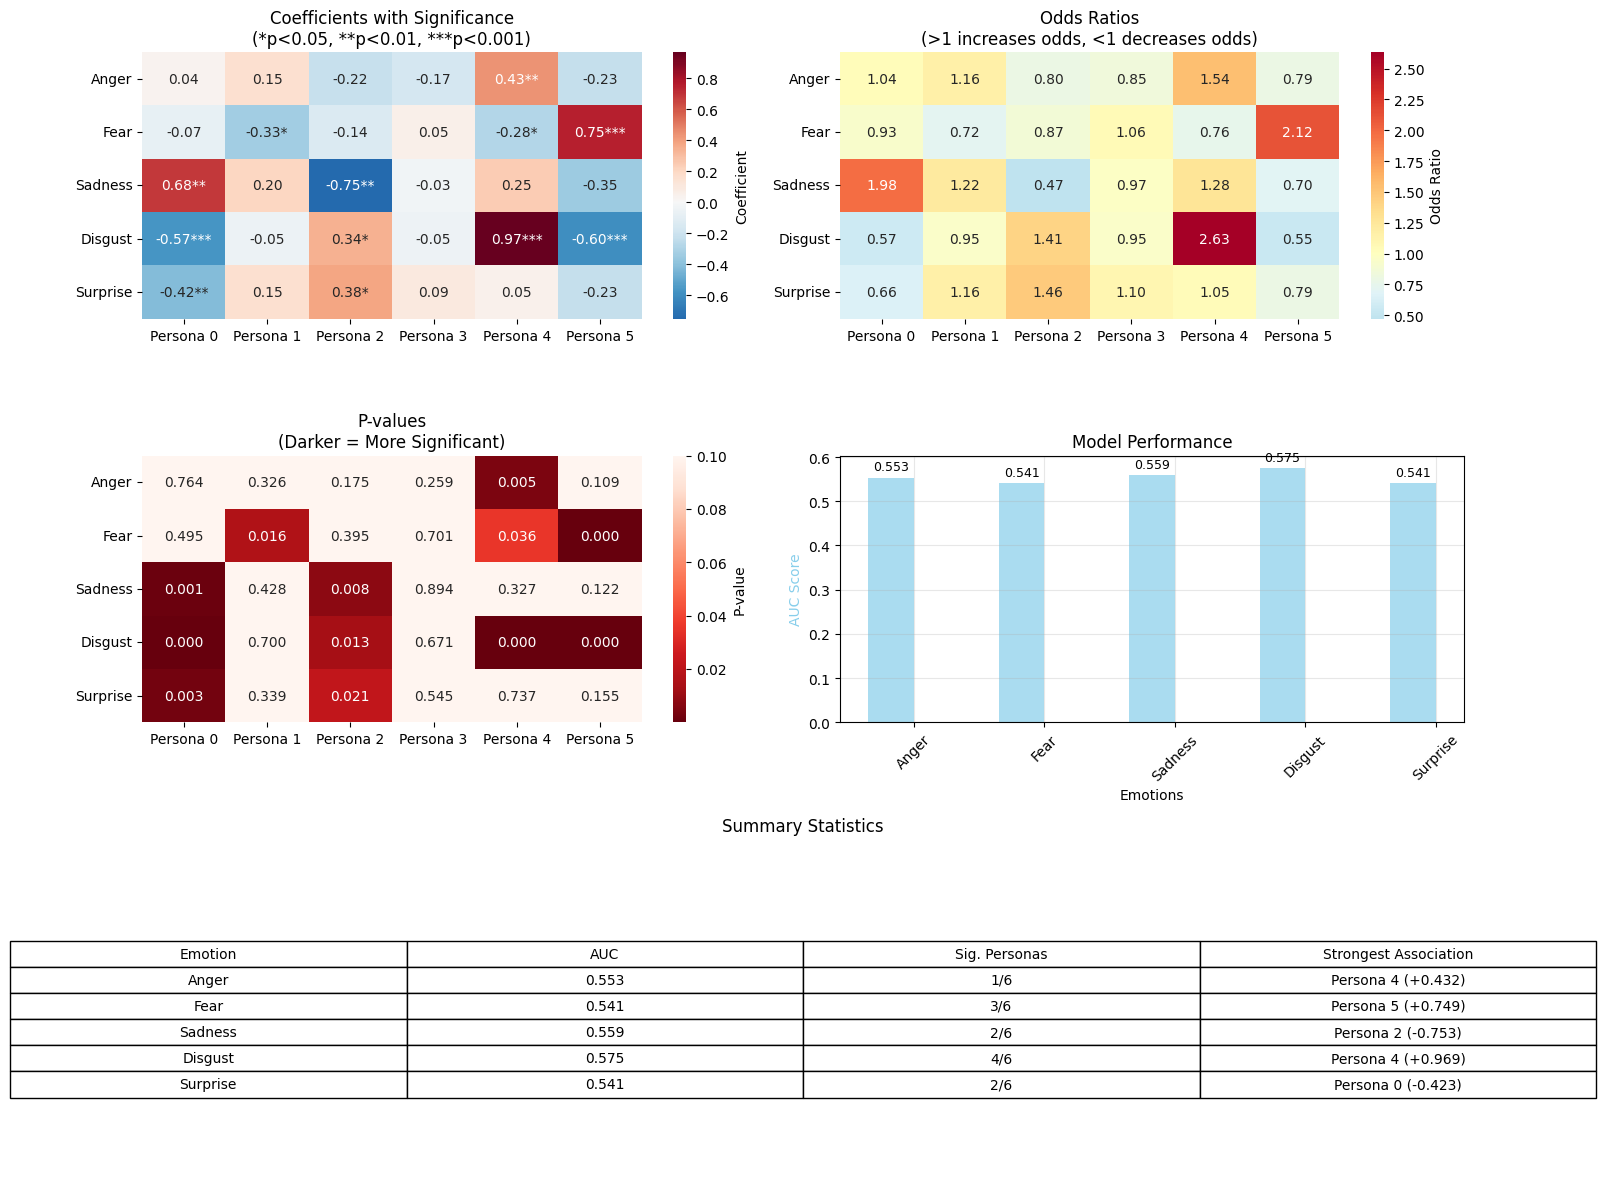

In [125]:
# Create comprehensive visualization
coef_df, p_value_df, or_df = create_comprehensive_visualization()

In [122]:
# Print detailed summary
print_detailed_summary()


DETAILED STATISTICAL SUMMARY

ANGER:
--------------------------------------------------
Significant associations:
  ✓ Persona 4: higher odds (OR=1.54, 95% CI=[1.18, 2.02], p=0.005)

Model fit: AUC=0.553

FEAR:
--------------------------------------------------
Significant associations:
  ✓ Persona 1: lower odds (OR=0.72, 95% CI=[0.57, 0.94], p=0.016)
  ✓ Persona 4: lower odds (OR=0.76, 95% CI=[0.58, 0.97], p=0.036)
  ✓ Persona 5: higher odds (OR=2.12, 95% CI=[1.67, 2.63], p=0.000)

Model fit: AUC=0.541

SADNESS:
--------------------------------------------------
Significant associations:
  ✓ Persona 0: higher odds (OR=1.98, 95% CI=[1.34, 2.96], p=0.001)
  ✓ Persona 2: lower odds (OR=0.47, 95% CI=[0.29, 0.89], p=0.008)

Model fit: AUC=0.559

DISGUST:
--------------------------------------------------
Significant associations:
  ✓ Persona 0: lower odds (OR=0.57, 95% CI=[0.47, 0.68], p=0.000)
  ✓ Persona 2: higher odds (OR=1.41, 95% CI=[1.08, 1.82], p=0.013)
  ✓ Persona 4: higher odds (O

In [123]:
# Access specific results
anger_results = results['Anger']
print(f"Anger model coefficients: {anger_results['coefficients']}")

Anger model coefficients: {'persona_0_prob': 0.03569106316246455, 'persona_1_prob': 0.15001813880355633, 'persona_2_prob': -0.22270517311860039, 'persona_3_prob': -0.16775544561644049, 'persona_4_prob': 0.43217237664763325, 'persona_5_prob': -0.23060374389595992}


##### 2. CLR

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

Data cleaning: 5749 → 5749 rows (100.0% retained)

Emotion distribution:
  Anger: 4216.0 posts (73.3%)
  Fear: 3646.0 posts (63.4%)
  Sadness: 5245.0 posts (91.2%)
  Disgust: 3374.0 posts (58.7%)
  Surprise: 1348.0 posts (23.4%)

COMPOSITIONAL DATA TRANSFORMATION
Original composition shape: (5749, 6)
Composition sum check (should be ~1.0): [1. 1. 1. 1. 1.]
ILR coordinates shape: (5749, 5)
ILR coordinate columns: ['ilr_coord_0', 'ilr_coord_1', 'ilr_coord_2', 'ilr_coord_3', 'ilr_coord_4']

ILR coordinate statistics:
       ilr_coord_0  ilr_coord_1  ilr_coord_2  ilr_coord_3  ilr_coord_4
count     5749.000     5749.000     5749.000     5749.000     5749.000
mean        -0.060        0.162       -0.045       -0.091       -0.224
std          1.232        1.017        1.114        1.119        1.133
min         -2.626       -2.800       -3.068       -3.225       -2.938
25%         -1.373       -0.005       -0.963       -1.139       -1.307
50%          0.001        0.004        0.558        0.

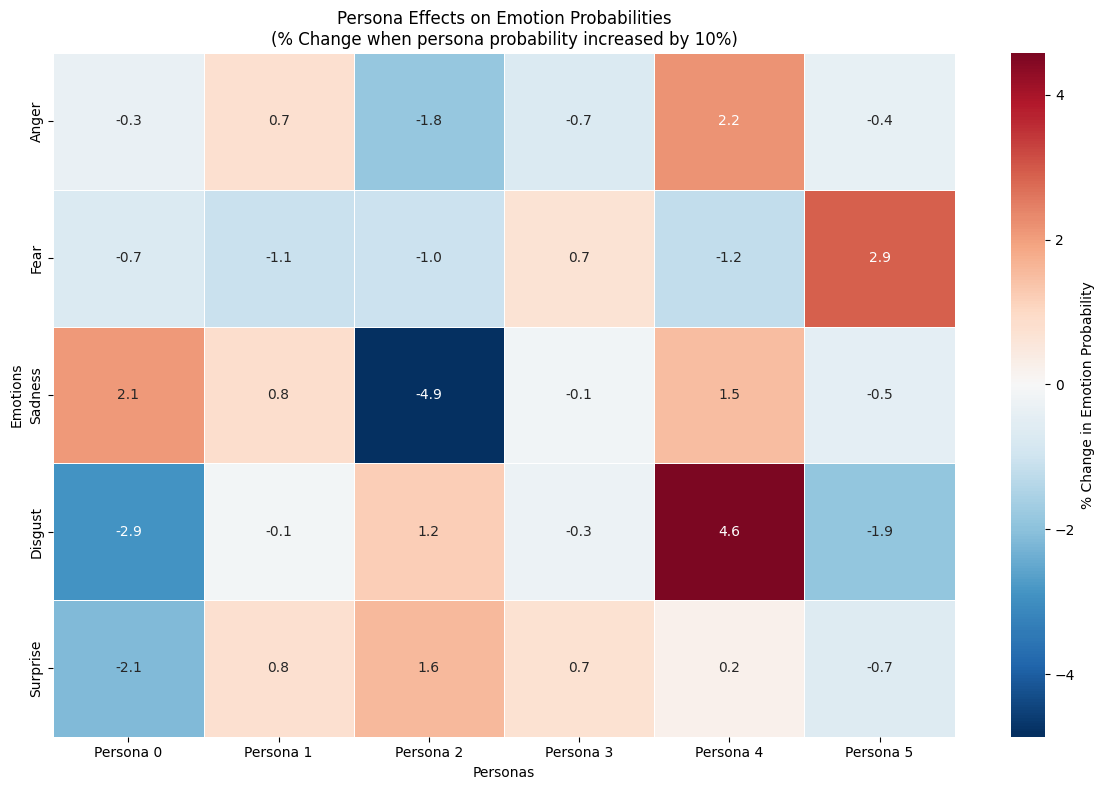


COMPREHENSIVE COMPOSITIONAL REGRESSION SUMMARY

Methodological Notes:
- Used Isometric Log-Ratio (ILR) transformation to handle compositional constraint
- Persona probabilities sum to 1, so standard regression assumptions violated
- ILR transforms 6D composition to 5D real space
- Interpretation focuses on relative persona effects via perturbation analysis


Model Performance Summary:
Emotion      AUC      Pseudo R²  Significant ILR Coords   
------------------------------------------------------------
Anger        0.535    0.003      1/5
Fear         0.537    0.006      2/5
Sadness      0.531    0.006      1/5
Disgust      0.578    0.015      4/5
Surprise     0.544    0.003      2/5


Key Findings (Persona Effects):

ANGER:

--- PERSONA EFFECT ANALYSIS FOR ANGER ---
Baseline persona probabilities:
  Persona 0: 0.179
  Persona 1: 0.172
  Persona 2: 0.126
  Persona 3: 0.159
  Persona 4: 0.169
  Persona 5: 0.195

Baseline anger probability: 0.501

Effect of increasing each persona by 0.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from scipy.special import logsumexp
import warnings
warnings.filterwarnings('ignore')

class CompositionalPersonaEmotionRegression:
    def __init__(self, df_post_w_persona):
        """
        Initialize compositional persona-emotion regression analysis
        
        Args:
            df_post_w_persona: DataFrame with persona probabilities and emotion labels
        """
        self.df = df_post_w_persona.copy()
        self.emotion_cols = ['emotion__anger', 'emotion__fear', 'emotion__sadness', 
                            'emotion__disgust', 'emotion__surprise']
        self.persona_cols = ['persona_0_prob', 'persona_1_prob', 'persona_2_prob', 
                            'persona_3_prob', 'persona_4_prob', 'persona_5_prob']
        self.models = {}
        self.results = {}
        
        # Clean data and prepare compositional transformations
        self.clean_data()
        self.prepare_compositional_data()
        
    def clean_data(self):
        """Clean data by removing rows with missing values in key columns"""
        required_cols = self.emotion_cols + self.persona_cols
        initial_rows = len(self.df)
        
        # Remove rows with any missing values in required columns
        self.df = self.df.dropna(subset=required_cols)
        
        # Remove rows where persona probabilities don't sum to ~1 (allow small numerical errors)
        prob_sums = self.df[self.persona_cols].sum(axis=1)
        valid_rows = np.abs(prob_sums - 1.0) < 0.01  # Allow 1% deviation
        self.df = self.df[valid_rows]
        
        final_rows = len(self.df)
        print(f"Data cleaning: {initial_rows} → {final_rows} rows ({final_rows/initial_rows:.1%} retained)")
        
        # Show emotion distribution
        print("\nEmotion distribution:")
        for emotion in self.emotion_cols:
            emotion_name = emotion.replace('emotion__', '').title()
            count = self.df[emotion].sum()
            percentage = (count / len(self.df)) * 100
            print(f"  {emotion_name}: {count} posts ({percentage:.1f}%)")
    
    def prepare_compositional_data(self):
        """
        Prepare compositional data using Isometric Log-Ratio (ILR) transformation
        """
        print("\n" + "="*60)
        print("COMPOSITIONAL DATA TRANSFORMATION")
        print("="*60)
        
        # Extract compositional data (persona probabilities)
        composition = self.df[self.persona_cols].values
        
        # Add small constant to avoid log(0) - replace zeros with small positive values
        epsilon = 1e-6
        composition = np.where(composition == 0, epsilon, composition)
        
        # Renormalize to ensure they sum to 1 after adding epsilon
        composition = composition / composition.sum(axis=1, keepdims=True)
        
        print(f"Original composition shape: {composition.shape}")
        print(f"Composition sum check (should be ~1.0): {composition.sum(axis=1)[:5]}")
        
        # Apply ILR transformation
        # ILR transforms D-dimensional compositional data to (D-1)-dimensional real space
        self.ilr_coords = self.ilr_transform(composition)
        
        # Create column names for ILR coordinates
        self.ilr_cols = [f'ilr_coord_{i}' for i in range(self.ilr_coords.shape[1])]
        
        # Add ILR coordinates to dataframe
        ilr_df = pd.DataFrame(self.ilr_coords, columns=self.ilr_cols, index=self.df.index)
        self.df = pd.concat([self.df, ilr_df], axis=1)
        
        print(f"ILR coordinates shape: {self.ilr_coords.shape}")
        print(f"ILR coordinate columns: {self.ilr_cols}")
        
        # Show ILR coordinate statistics
        print(f"\nILR coordinate statistics:")
        print(ilr_df.describe().round(3))
    
    def ilr_transform(self, composition):
        """
        Apply Isometric Log-Ratio (ILR) transformation to compositional data
        
        Args:
            composition: numpy array of shape (n_samples, n_components)
            
        Returns:
            ilr_coords: numpy array of shape (n_samples, n_components-1)
        """
        n_samples, n_parts = composition.shape
        
        # Create orthonormal basis for ILR (Helmert sub-matrix)
        # This is a standard approach for ILR transformation
        ilr_basis = np.zeros((n_parts, n_parts - 1))
        
        for i in range(n_parts - 1):
            # Create i-th ILR coordinate
            for j in range(i + 1):
                ilr_basis[j, i] = 1.0 / np.sqrt((i + 1) * (i + 2))
            ilr_basis[i + 1, i] = -np.sqrt((i + 1) / (i + 2))
        
        # Apply ILR transformation: ilr = log(composition) @ basis
        log_composition = np.log(composition)
        ilr_coords = log_composition @ ilr_basis
        
        return ilr_coords
    
    def inverse_ilr_transform(self, ilr_coords):
        """
        Inverse ILR transformation to get back compositional data
        """
        n_samples, n_coords = ilr_coords.shape
        n_parts = n_coords + 1
        
        # Reconstruct orthonormal basis
        ilr_basis = np.zeros((n_parts, n_coords))
        for i in range(n_coords):
            for j in range(i + 1):
                ilr_basis[j, i] = 1.0 / np.sqrt((i + 1) * (i + 2))
            ilr_basis[i + 1, i] = -np.sqrt((i + 1) / (i + 2))
        
        # Inverse transformation
        log_composition = ilr_coords @ ilr_basis.T
        
        # Convert back to compositional space
        composition = np.exp(log_composition)
        composition = composition / composition.sum(axis=1, keepdims=True)
        
        return composition
    
    def fit_emotion_models(self, test_size=0.2, random_state=42, alpha=0.05):
        """
        Fit logistic regression models using ILR-transformed compositional data
        """
        print("\n" + "="*60)
        print("FITTING EMOTION MODELS WITH ILR TRANSFORMATION")
        print("="*60)
        
        self.alpha = alpha
        
        # Use ILR coordinates as features
        X = self.df[self.ilr_cols]
        
        for emotion_col in self.emotion_cols:
            emotion_name = emotion_col.replace('emotion__', '').title()
            y = self.df[emotion_col]
            
            print(f"\n--- {emotion_name.upper()} ---")
            
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state, stratify=y
            )
            
            # Fit with statsmodels for statistical inference
            X_train_sm = sm.add_constant(X_train)
            X_test_sm = sm.add_constant(X_test)
            
            # Fit statsmodels logistic regression
            logit_model = sm.Logit(y_train, X_train_sm)
            fitted_model = logit_model.fit(disp=0)
            
            # Also fit sklearn model for predictions
            sklearn_model = LogisticRegression(
                random_state=random_state,
                max_iter=1000,
                class_weight='balanced'
            )
            sklearn_model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = sklearn_model.predict(X_test)
            y_pred_proba = sklearn_model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            auc_score = roc_auc_score(y_test, y_pred_proba)
            
            # Extract statistical results
            coefficients = {}
            p_values = {}
            conf_intervals = {}
            
            for i, col in enumerate(self.ilr_cols):
                coefficients[col] = fitted_model.params[col]
                p_values[col] = fitted_model.pvalues[col]
                conf_intervals[col] = fitted_model.conf_int().loc[col].values
            
            # Store results
            self.models[emotion_name] = sklearn_model
            self.results[emotion_name] = {
                'sklearn_model': sklearn_model,
                'statsmodels_model': fitted_model,
                'coefficients': coefficients,
                'p_values': p_values,
                'conf_intervals': conf_intervals,
                'intercept': fitted_model.params['const'],
                'intercept_pvalue': fitted_model.pvalues['const'],
                'auc_score': auc_score,
                'y_test': y_test,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'pseudo_r2': fitted_model.prsquared
            }
            
            print(f"AUC Score: {auc_score:.3f}")
            print(f"Pseudo R²: {fitted_model.prsquared:.3f}")
            
            # Interpret results in terms of original persona space
            self.interpret_compositional_effects(emotion_name)
    
    def interpret_compositional_effects(self, emotion_name):
        """
        Interpret ILR coefficients in terms of persona effects
        """
        results = self.results[emotion_name]
        coefficients = results['coefficients']
        p_values = results['p_values']
        conf_intervals = results['conf_intervals']
        
        print(f"\nILR Coefficient Interpretation for {emotion_name}:")
        print(f"{'ILR Coord':<12} {'Coeff':<8} {'P-value':<10} {'95% CI':<25} {'Significance':<15}")
        print("-" * 80)
        
        for coord in self.ilr_cols:
            coef = coefficients[coord]
            p_val = p_values[coord]
            ci = conf_intervals[coord]
            
            # Determine significance
            if p_val < 0.001:
                sig_level = "***"
            elif p_val < 0.01:
                sig_level = "**"
            elif p_val < 0.05:
                sig_level = "*"
            else:
                sig_level = "n.s."
            
            ci_str = f"[{ci[0]:.3f}, {ci[1]:.3f}]"
            print(f"{coord:<12} {coef:+.3f}    {p_val:.4f}     {ci_str:<25} {sig_level:<15}")
        
        print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant")
        
        # Provide interpretation guidance
        print(f"\nInterpretation Guide for {emotion_name}:")
        print("- ILR coordinates represent log-ratio relationships between personas")
        print("- Positive coefficients indicate that increases in certain persona ratios")
        print("  are associated with higher odds of this emotion")
        print("- Use persona effect analysis below for clearer interpretation")
    
    def analyze_persona_effects(self, emotion_name, perturbation_size=0.1):
        """
        Analyze the effect of each persona on emotion probability by perturbation
        
        Args:
            emotion_name: Name of the emotion to analyze
            perturbation_size: How much to increase each persona probability
        """
        print(f"\n--- PERSONA EFFECT ANALYSIS FOR {emotion_name.upper()} ---")
        
        if emotion_name not in self.results:
            print(f"Model for {emotion_name} not found!")
            return
        
        model = self.results[emotion_name]['sklearn_model']
        
        # Use mean composition as baseline
        mean_composition = self.df[self.persona_cols].mean().values
        
        print(f"Baseline persona probabilities:")
        for i, prob in enumerate(mean_composition):
            print(f"  Persona {i}: {prob:.3f}")
        
        # Calculate baseline emotion probability
        baseline_ilr = self.ilr_transform(mean_composition.reshape(1, -1))
        baseline_prob = model.predict_proba(baseline_ilr)[0, 1]
        
        print(f"\nBaseline {emotion_name.lower()} probability: {baseline_prob:.3f}")
        
        # Analyze effect of increasing each persona
        persona_effects = {}
        
        print(f"\nEffect of increasing each persona by {perturbation_size}:")
        print(f"{'Persona':<10} {'New Prob':<10} {'Change':<10} {'% Change':<12} {'Effect':<10}")
        print("-" * 65)
        
        for i in range(len(self.persona_cols)):
            # Create perturbed composition
            perturbed_comp = mean_composition.copy()
            perturbed_comp[i] += perturbation_size
            
            # Renormalize
            perturbed_comp = perturbed_comp / perturbed_comp.sum()
            
            # Transform and predict
            perturbed_ilr = self.ilr_transform(perturbed_comp.reshape(1, -1))
            perturbed_prob = model.predict_proba(perturbed_ilr)[0, 1]
            
            # Calculate effect
            absolute_change = perturbed_prob - baseline_prob
            percent_change = (absolute_change / baseline_prob) * 100
            
            effect_direction = "Increase" if absolute_change > 0 else "Decrease"
            
            persona_effects[f'Persona {i}'] = {
                'new_prob': perturbed_prob,
                'absolute_change': absolute_change,
                'percent_change': percent_change,
                'direction': effect_direction
            }
            
            print(f"Persona {i:<3}    {perturbed_prob:.3f}      {absolute_change:+.3f}      "
                  f"{percent_change:+.1f}%        {effect_direction:<10}")
        
        return persona_effects
    
    def create_persona_effect_heatmap(self, figsize=(12, 8)):
        """
        Create heatmap showing persona effects across all emotions
        """
        if not self.results:
            print("No models fitted yet. Run fit_emotion_models() first.")
            return
        
        # Calculate persona effects for all emotions
        all_effects = {}
        
        for emotion_name in self.results.keys():
            effects = self.analyze_persona_effects(emotion_name, perturbation_size=0.1)
            
            # Extract percent changes
            percent_changes = [effects[f'Persona {i}']['percent_change'] 
                             for i in range(6)]
            all_effects[emotion_name] = percent_changes
        
        # Create DataFrame
        effect_df = pd.DataFrame(
            all_effects,
            index=[f'Persona {i}' for i in range(6)]
        ).T
        
        # Create heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(effect_df, 
                   annot=True, 
                   fmt='.1f', 
                   cmap='RdBu_r',
                   center=0,
                   cbar_kws={'label': '% Change in Emotion Probability'},
                   linewidths=0.5)
        
        plt.title('Persona Effects on Emotion Probabilities\n'
                 '(% Change when persona probability increased by 10%)')
        plt.xlabel('Personas')
        plt.ylabel('Emotions')
        plt.tight_layout()
        plt.show()
        
        return effect_df
    
    def print_comprehensive_summary(self):
        """
        Print comprehensive summary with compositional interpretation
        """
        print("\n" + "="*100)
        print("COMPREHENSIVE COMPOSITIONAL REGRESSION SUMMARY")
        print("="*100)
        
        print(f"\nMethodological Notes:")
        print(f"- Used Isometric Log-Ratio (ILR) transformation to handle compositional constraint")
        print(f"- Persona probabilities sum to 1, so standard regression assumptions violated")
        print(f"- ILR transforms {len(self.persona_cols)}D composition to {len(self.ilr_cols)}D real space")
        print(f"- Interpretation focuses on relative persona effects via perturbation analysis")
        
        print(f"\n\nModel Performance Summary:")
        print(f"{'Emotion':<12} {'AUC':<8} {'Pseudo R²':<10} {'Significant ILR Coords':<25}")
        print("-" * 60)
        
        for emotion_name, results in self.results.items():
            auc = results['auc_score']
            pseudo_r2 = results['pseudo_r2']
            p_values = results['p_values']
            sig_coords = sum(1 for p in p_values.values() if p < self.alpha)
            
            print(f"{emotion_name:<12} {auc:.3f}    {pseudo_r2:.3f}      "
                  f"{sig_coords}/{len(self.ilr_cols)}")
        
        print(f"\n\nKey Findings (Persona Effects):")
        print("="*50)
        
        # Summarize strongest persona effects
        for emotion_name in self.results.keys():
            print(f"\n{emotion_name.upper()}:")
            effects = self.analyze_persona_effects(emotion_name, perturbation_size=0.1)
            
            # Find strongest positive and negative effects
            effects_list = [(persona, data['percent_change']) 
                          for persona, data in effects.items()]
            effects_list.sort(key=lambda x: abs(x[1]), reverse=True)
            
            strongest_effect = effects_list[0]
            direction = "increases" if strongest_effect[1] > 0 else "decreases"
            
            print(f"  Strongest effect: {strongest_effect[0]} {direction} "
                  f"probability by {abs(strongest_effect[1]):.1f}%")

# Usage example:
# Initialize the compositional analysis
comp_analysis = CompositionalPersonaEmotionRegression(df_clean)

# Fit models with ILR transformation
comp_analysis.fit_emotion_models()

# Create persona effect visualizations
effect_df = comp_analysis.create_persona_effect_heatmap()

# Print comprehensive summary
comp_analysis.print_comprehensive_summary()

# Analyze specific emotion in detail
anger_effects = comp_analysis.analyze_persona_effects('Anger')

##### 3. CLR + Regularization

In [138]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [143]:
def centered_log_ratio_transform(X, epsilon = 1e-8):
    """Apply Centered Log-Ratio transformation to compositional data"""
    # Add small epsilon to handle zeros
    X_adj = X + epsilon
    
    # Renormalize to ensure they still sum to 1
    X_adj = X_adj.div(X_adj.sum(axis=1), axis=0)
    
    # Calculate geometric mean for each observation
    geometric_mean = np.exp(np.log(X_adj).mean(axis=1))
    
    # Apply CLR transformation
    clr = np.log(X_adj).sub(np.log(geometric_mean), axis=0)
    
    return clr

In [148]:
def fit_emotion_models(cv_folds=5, alphas=None):
    """
    Fit logistic regression models for each emotion using CLR-transformed features
    """
    if alphas is None:
        alphas = np.logspace(-4, 2, 50)
    
    # Extract and transform persona probabilities
    persona_probs = df_clean[persona_cols]
    clr_features = centered_log_ratio_transform(persona_probs)
    clr_features.columns = [f'CLR_{col}' for col in persona_cols]
    
    # Standardize CLR features
    scaler = StandardScaler()
    clr_scaled = scaler.fit_transform(clr_features)
    clr_scaled_df = pd.DataFrame(clr_scaled, 
                                      columns=clr_features.columns,
                                      index=clr_features.index)
    results = {}
    
    for emotion in emotion_cols:
        print(f"\n=== Analyzing {emotion.replace('emotion__', '').upper()} ===")
        
        y = df_clean[emotion]
        
        # Check class balance
        pos_rate = y.mean()
        print(f"Positive class rate: {pos_rate:.3f}")
        
        if pos_rate < 0.01 or pos_rate > 0.99:
            print(f"Warning: Extremely imbalanced classes for {emotion}")
        
        # Use LogisticRegressionCV with elasticnet for feature selection
        model = LogisticRegressionCV(
            Cs=1/alphas,  # Convert alphas to C values
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.1, 0.5, 0.7, 0.9],  # Mix of L1 and L2
            max_iter=1000,
            random_state=42,
            scoring='roc_auc' if pos_rate > 0.1 else 'balanced_accuracy'
        )
        
        # Fit model
        model.fit(clr_scaled, y)
        
        # Cross-validation performance
        cv_scores = cross_val_score(
            model, clr_scaled, y, 
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
            scoring='roc_auc' if pos_rate > 0.1 else 'balanced_accuracy'
        )
        
        # Store results
        results[emotion] = {
            'model': model,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'coefficients': model.coef_[0],
            'feature_names': clr_features.columns.tolist(),
            'best_C': model.C_[0],
            'best_l1_ratio': model.l1_ratio_[0]
        }
        
        print(f"Cross-validation {model.scoring}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        print(f"Best C: {model.C_[0]:.4f}, Best L1 ratio: {model.l1_ratio_[0]:.3f}")
    return results, clr_scaled_df

In [149]:
# Fit models
results, clr_scaled = fit_emotion_models() 


=== Analyzing ANGER ===
Positive class rate: 0.733
Cross-validation roc_auc: 0.531 ± 0.020
Best C: 0.0543, Best L1 ratio: 0.700

=== Analyzing FEAR ===
Positive class rate: 0.634
Cross-validation roc_auc: 0.547 ± 0.017
Best C: 0.0954, Best L1 ratio: 0.500

=== Analyzing SADNESS ===
Positive class rate: 0.912
Cross-validation roc_auc: 0.553 ± 0.035
Best C: 0.0176, Best L1 ratio: 0.700

=== Analyzing DISGUST ===
Positive class rate: 0.587
Cross-validation roc_auc: 0.579 ± 0.018
Best C: 8.6851, Best L1 ratio: 0.100

=== Analyzing SURPRISE ===
Positive class rate: 0.234
Cross-validation roc_auc: 0.542 ± 0.013
Best C: 0.0133, Best L1 ratio: 0.700


In [150]:
def interpret_coefficients(results, min_coeff_threshold=0.01):
    """
    Interpret the coefficients with proper compositional data interpretation
    """
    print("\n" + "="*70)
    print("COEFFICIENT INTERPRETATION")
    print("="*70)
    
    interpretation_df = []
    
    for emotion, result in results.items():
        emotion_name = emotion.replace('emotion__', '').upper()
        coeffs = result['coefficients']
        features = result['feature_names']
        
        print(f"\n{emotion_name}:")
        print("-" * (len(emotion_name) + 1))
        
        # Sort coefficients by magnitude
        coeff_df = pd.DataFrame({
            'Feature': features,
            'Coefficient': coeffs,
            'Abs_Coefficient': np.abs(coeffs)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        # Only show coefficients above threshold
        significant_coeffs = coeff_df[coeff_df['Abs_Coefficient'] > min_coeff_threshold]
        
        if len(significant_coeffs) == 0:
            print("No coefficients above threshold - model may not be informative")
            continue
            
        for _, row in significant_coeffs.iterrows():
            persona_num = row['Feature'].replace('CLR_persona_', '').replace('_prob', '')
            direction = "increases" if row['Coefficient'] > 0 else "decreases"
            
            print(f"  Persona {persona_num}: {row['Coefficient']:+.4f}")
            print(f"    → Higher probability of Persona {persona_num} {direction} odds of {emotion_name}")
            
            # Store for summary
            interpretation_df.append({
                'Emotion': emotion_name,
                'Persona': persona_num,
                'Coefficient': row['Coefficient'],
                'Direction': 'Increases' if row['Coefficient'] > 0 else 'Decreases'
            })
    
    interpretation_df = pd.DataFrame(interpretation_df)
    return interpretation_df

In [152]:
def plot_coefficient_heatmap(results, figsize=(12, 8)):
    """Create a heatmap of coefficients"""
    # Create coefficient matrix
    emotions = [e.replace('emotion__', '').title() for e in emotion_cols]
    personas = [f'Persona {i}' for i in range(len(persona_cols))]
    
    coeff_matrix = np.zeros((len(emotions), len(personas)))
    
    for i, emotion in enumerate(emotion_cols):
        if emotion in results:
            coeff_matrix[i, :] = results[emotion]['coefficients']
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(coeff_matrix, 
               annot=True, 
               fmt='.3f',
               xticklabels=personas,
               yticklabels=emotions,
               center=0,
               cmap='RdBu_r',
               cbar_kws={'label': 'CLR Coefficient'})
    
    plt.title('Persona-Emotion Association Coefficients\n(CLR-transformed with Regularization)')
    plt.xlabel('Persona Type')
    plt.ylabel('Emotion')
    plt.tight_layout()
    return plt.gcf()

def statistical_significance_bootstrap(results, clr_scaled_df, n_bootstrap=1000):
    """
    Estimate coefficient confidence intervals using bootstrap
    """
    print("\n" + "="*70)
    print("STATISTICAL SIGNIFICANCE (Bootstrap Confidence Intervals)")
    print("="*70)
    
    significance_results = {}
    
    for emotion, result in results.items():
        print(f"\n{emotion.replace('emotion__', '').upper()}:")
        print("-" * 40)
        
        model = result['model']
        y = df_clean[emotion]
        X = clr_scaled_df
        
        # Bootstrap sampling
        bootstrap_coeffs = []
        n_samples = len(y)
        
        for _ in range(n_bootstrap):
            # Sample with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot = X.iloc[indices]
            y_boot = y.iloc[indices]
            
            # Fit model on bootstrap sample
            boot_model = LogisticRegression(
                C=model.C_[0],
                penalty='elasticnet',
                l1_ratio=model.l1_ratio_[0],
                solver='saga',
                max_iter=1000,
                random_state=None
            )
            
            try:
                boot_model.fit(X_boot, y_boot)
                bootstrap_coeffs.append(boot_model.coef_[0])
            except:
                continue  # Skip failed fits
        
        if len(bootstrap_coeffs) < 100:
            print("Warning: Many bootstrap samples failed to converge")
            continue
            
        bootstrap_coeffs = np.array(bootstrap_coeffs)
        
        # Calculate confidence intervals
        ci_lower = np.percentile(bootstrap_coeffs, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_coeffs, 97.5, axis=0)
        
        # Check significance (CI doesn't include 0)
        feature_names = result['feature_names']
        original_coeffs = result['coefficients']
        
        sig_results = []
        for i, feature in enumerate(feature_names):
            is_significant = not (ci_lower[i] <= 0 <= ci_upper[i])
            persona_num = feature.replace('CLR_persona_', '').replace('_prob', '')
            
            sig_results.append({
                'persona': persona_num,
                'coefficient': original_coeffs[i],
                'ci_lower': ci_lower[i],
                'ci_upper': ci_upper[i],
                'significant': is_significant
            })
            
            if is_significant:
                print(f"  Persona {persona_num}: {original_coeffs[i]:+.4f} "
                      f"[{ci_lower[i]:+.3f}, {ci_upper[i]:+.3f}] *")
            else:
                print(f"  Persona {persona_num}: {original_coeffs[i]:+.4f} "
                      f"[{ci_lower[i]:+.3f}, {ci_upper[i]:+.3f}]")
        
        significance_results[emotion] = sig_results
        print("  (* indicates 95% CI doesn't include 0)")
    
    return significance_results

def summary_report(results, interpretation_df, significance_results):
    """Generate a comprehensive summary report"""
    print("\n" + "="*80)
    print("COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\nDataset: {len(df_clean)} posts analyzed")
    print(f"Features: {len(persona_cols)} persona probabilities (CLR-transformed)")
    print(f"Outcomes: {len(emotion_cols)} emotions")
    
    # Model performance summary
    print("\n1. MODEL PERFORMANCE:")
    print("-" * 30)
    for emotion, result in results.items():
        emotion_name = emotion.replace('emotion__', '').title()
        print(f"{emotion_name:12s}: {result['cv_mean']:.3f} ± {result['cv_std']:.3f}")
    
    # Key findings
    print("\n2. KEY FINDINGS:")
    print("-" * 30)
    strong_associations = interpretation_df[
        np.abs(interpretation_df['Coefficient']) > 0.1
    ].sort_values('Coefficient', key=abs, ascending=False)
    
    if len(strong_associations) > 0:
        print("Strongest persona-emotion associations:")
        for _, row in strong_associations.head(10).iterrows():
            print(f"  • Persona {row['Persona']} → {row['Emotion']}: "
                  f"{row['Coefficient']:+.3f} ({row['Direction']})")
    else:
        print("No strong associations found (coefficients < 0.1)")
    
    # Statistical significance
    print("\n3. STATISTICAL SIGNIFICANCE:")
    print("-" * 30)
    total_sig = 0
    total_tests = 0
    for emotion, sig_list in significance_results.items():
        sig_count = sum(1 for s in sig_list if s['significant'])
        total_sig += sig_count
        total_tests += len(sig_list)
        emotion_name = emotion.replace('emotion__', '').title()
        print(f"{emotion_name:12s}: {sig_count}/{len(sig_list)} significant associations")
    
    print(f"\nOverall: {total_sig}/{total_tests} significant associations "
          f"({100*total_sig/total_tests:.1f}%)")


COEFFICIENT INTERPRETATION

ANGER:
------
  Persona 4: +0.0838
    → Higher probability of Persona 4 increases odds of ANGER
  Persona 1: +0.0436
    → Higher probability of Persona 1 increases odds of ANGER
  Persona 2: -0.0373
    → Higher probability of Persona 2 decreases odds of ANGER
  Persona 3: -0.0103
    → Higher probability of Persona 3 decreases odds of ANGER

FEAR:
-----
  Persona 5: +0.1596
    → Higher probability of Persona 5 increases odds of FEAR
  Persona 3: +0.0604
    → Higher probability of Persona 3 increases odds of FEAR
  Persona 2: -0.0170
    → Higher probability of Persona 2 decreases odds of FEAR
  Persona 1: -0.0166
    → Higher probability of Persona 1 decreases odds of FEAR

SADNESS:
--------
  Persona 2: -0.0491
    → Higher probability of Persona 2 decreases odds of SADNESS
  Persona 0: +0.0117
    → Higher probability of Persona 0 increases odds of SADNESS

DISGUST:
--------
  Persona 4: +0.1980
    → Higher probability of Persona 4 increases odds of

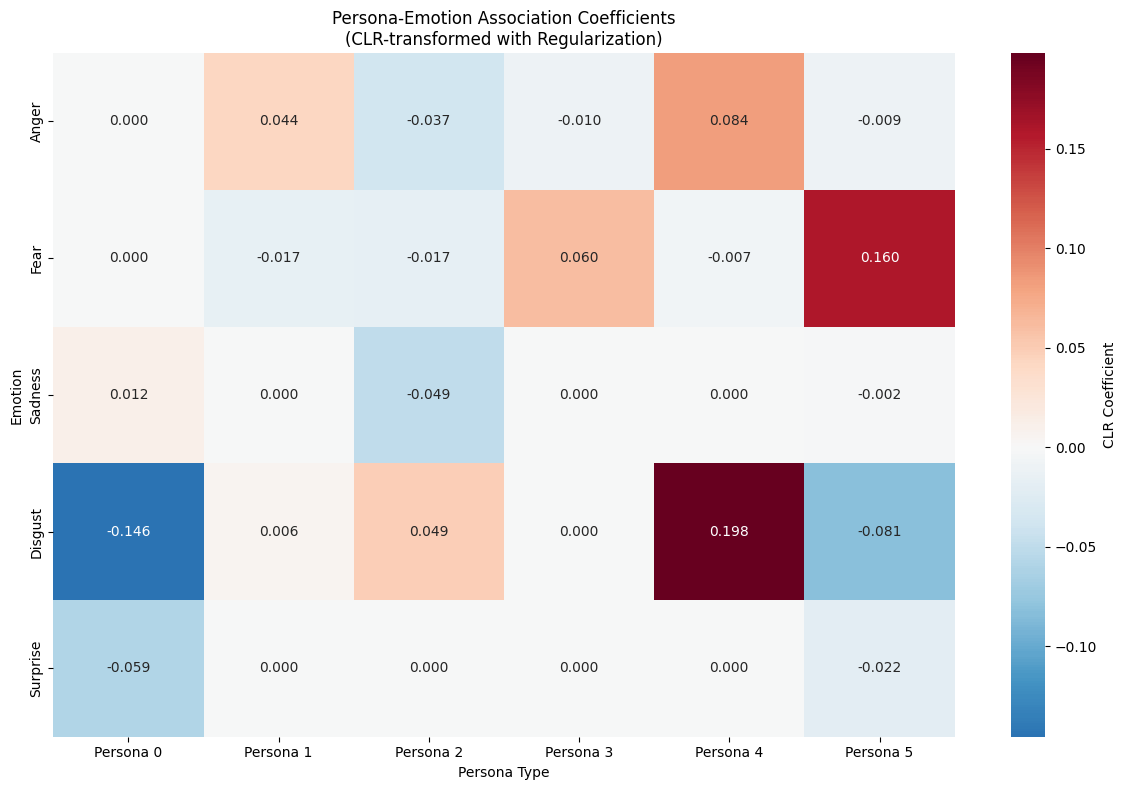


STATISTICAL SIGNIFICANCE (Bootstrap Confidence Intervals)

ANGER:
----------------------------------------
  Persona 0: +0.0000 [-0.039, +0.011]
  Persona 1: +0.0436 [+0.000, +0.094]
  Persona 2: -0.0373 [-0.102, +0.000]
  Persona 3: -0.0103 [-0.074, +0.014]
  Persona 4: +0.0838 [+0.015, +0.137] *
  Persona 5: -0.0089 [-0.073, +0.000]
  (* indicates 95% CI doesn't include 0)

FEAR:
----------------------------------------
  Persona 0: +0.0000 [-0.053, +0.004]
  Persona 1: -0.0166 [-0.081, +0.000]
  Persona 2: -0.0170 [-0.080, +0.021]
  Persona 3: +0.0604 [+0.000, +0.110]
  Persona 4: -0.0071 [-0.070, +0.006]
  Persona 5: +0.1596 [+0.096, +0.205] *
  (* indicates 95% CI doesn't include 0)

SADNESS:
----------------------------------------
  Persona 0: +0.0117 [+0.000, +0.082]
  Persona 1: +0.0000 [+0.000, +0.000]
  Persona 2: -0.0491 [-0.135, +0.000]
  Persona 3: +0.0000 [+0.000, +0.000]
  Persona 4: +0.0000 [+0.000, +0.055]
  Persona 5: -0.0020 [-0.090, +0.000]
  (* indicates 95% CI d

In [153]:
# Interpret results
interpretation = interpret_coefficients(results) 
# Create visualization
fig = plot_coefficient_heatmap(results)
plt.show() 
# Statistical significance testing
significance = statistical_significance_bootstrap(results, clr_scaled) 
# Generate summary
summary_report(results, interpretation, significance)

In general:
* **Persona 4 (Conservative Identity Protector)** shows the strongest and most consistent emotional associations, significantly increases **anger** and **disgust** --> hostile and aggressive, adopted extreme ideologies that are especially repulsive to their loved ones.
* **Persona 5 (Pandemic-Triggered Skeptic)** predominantly induce **fear** and **disgust** --> makes family members genuinely afraid, threatened and infuriated
* **Persona 0 (Health-Triggered Conspiracy Theorist)**: appears to represent a "cleaner" or more palatable form of radicalization that doesn't trigger disgust responses?

* **Sadness & Surprise**: Very weak associations overall - these emotions may be less discriminative for persona types (maybe it's felt equally across all?)

Implications:
* The emotional toll on families varies systematically by radicalization pathways
* Fear and disgust appear most discriminative across persona types, while sadness and surprise seem to be "baseline responses" regardless of pathway

##### M2-3: Persona + control variables

In [174]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

emotion_cols = ['emotion__anger', 'emotion__fear', 'emotion__sadness', 'emotion__disgust', 'emotion__surprise']
persona_cols = ['persona_0_prob', 'persona_1_prob', 'persona_2_prob', 'persona_3_prob', 'persona_4_prob', 'persona_5_prob']

def centered_log_ratio_transform(X, epsilon = 1e-8):
    """Apply Centered Log-Ratio transformation to compositional data"""
    # Add small epsilon to handle zeros
    X_adj = X + epsilon
    
    # Renormalize to ensure they still sum to 1
    X_adj = X_adj.div(X_adj.sum(axis=1), axis=0)
    
    # Calculate geometric mean for each observation
    geometric_mean = np.exp(np.log(X_adj).mean(axis=1))
    
    # Apply CLR transformation
    clr = np.log(X_adj).sub(np.log(geometric_mean), axis=0)
    
    return clr

def create_effects_coding(df, column, prefix=None):
    """
    Create effects coding (deviation coding) for categorical variables
    Effects coding contrasts each category with the grand mean
    """
    if prefix is None:
        prefix = column
    
    categories = df[column].unique()
    n_categories = len(categories)
    
    # Create effects coding matrix (n_categories - 1 columns)
    effects_df = pd.DataFrame(index=df.index)
    
    for i, category in enumerate(categories[:-1]):  # Exclude last category as reference
        col_name = f"{prefix}_{category}"
        effects_df[col_name] = 0
        
        # Set to 1 for the focal category
        effects_df.loc[df[column] == category, col_name] = 1
        
        # Set to -1 for the reference category (last category)
        effects_df.loc[df[column] == categories[-1], col_name] = -1
    
    return effects_df

def prepare_features(df, model_type='persona_only'):
    """
    Prepare feature matrices for different model specifications
    """
    # Always start with CLR-transformed persona probabilities
    persona_probs = df[persona_cols]
    clr_features = centered_log_ratio_transform(persona_probs)
    clr_features.columns = [f'CLR_{col}' for col in persona_cols]
    
    feature_df = clr_features.copy()
    feature_names = list(clr_features.columns)
    
    if model_type == 'persona_only':
        pass  # Already have CLR features
        
    elif model_type == 'persona_relationship':
        # Add relationship effects coding
        relationship_effects = create_effects_coding(df, 'relationship_cat', 'relationship')
        feature_df = pd.concat([feature_df, relationship_effects], axis=1)
        feature_names.extend(relationship_effects.columns.tolist())
        
    elif model_type == 'persona_relationship_demographics':
        # Add relationship effects coding
        relationship_effects = create_effects_coding(df, 'relationship_cat', 'relationship')
        feature_df = pd.concat([feature_df, relationship_effects], axis=1)
        feature_names.extend(relationship_effects.columns.tolist())
        
        # Add gender effects coding
        gender_effects = create_effects_coding(df, 'gender', 'gender')
        feature_df = pd.concat([feature_df, gender_effects], axis=1)
        feature_names.extend(gender_effects.columns.tolist())
        
        # Add age_group effects coding
        age_effects = create_effects_coding(df, 'age_group', 'age')
        feature_df = pd.concat([feature_df, age_effects], axis=1)
        feature_names.extend(age_effects.columns.tolist())
    
    # Standardize all features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)
    scaled_df = pd.DataFrame(scaled_features, 
                            columns=feature_names,
                            index=feature_df.index)
    
    return scaled_df, feature_names, scaler

def calculate_bic(model, X, y):
    """
    Calculate Bayesian Information Criterion (BIC) for logistic regression
    BIC = -2 * log_likelihood + k * log(n)
    where k is number of parameters and n is sample size
    """
    # Get predicted probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Calculate log-likelihood
    log_likelihood = -log_loss(y, y_pred_proba, normalize=False)
    
    # Number of parameters (coefficients + intercept)
    k = len(model.coef_[0]) + 1
    n = len(y)
    
    # Calculate BIC
    bic = -2 * log_likelihood + k * np.log(n)
    
    return bic

def fit_emotion_models_extended(df, cv_folds=5, alphas=None):
    """
    Fit logistic regression models for each emotion using different feature sets
    """
    if alphas is None:
        alphas = np.logspace(-4, 2, 50)
    
    model_types = ['persona_only', 'persona_relationship', 'persona_relationship_demographics']
    all_results = {}
    
    for model_type in model_types:
        print(f"\n{'='*80}")
        print(f"FITTING MODELS: {model_type.upper().replace('_', ' + ')}")
        print(f"{'='*80}")
        
        # Prepare features for this model type
        X_scaled, feature_names, scaler = prepare_features(df, model_type)
        
        results = {}
        
        for emotion in emotion_cols:
            print(f"\n=== Analyzing {emotion.replace('emotion__', '').upper()} ===")
            
            y = df[emotion]
            
            # Check class balance
            pos_rate = y.mean()
            print(f"Positive class rate: {pos_rate:.3f}")
            print(f"Number of features: {len(feature_names)}")
            
            if pos_rate < 0.01 or pos_rate > 0.99:
                print(f"Warning: Extremely imbalanced classes for {emotion}")
            
            # Use LogisticRegressionCV with elasticnet for feature selection
            model = LogisticRegressionCV(
                Cs=1/alphas,  # Convert alphas to C values
                cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.1, 0.5, 0.7, 0.9],  # Mix of L1 and L2
                max_iter=2000,  # Increased for more complex models
                random_state=42,
                scoring='roc_auc' if pos_rate > 0.1 else 'balanced_accuracy'
            )
            
            # Fit model
            model.fit(X_scaled, y)
            
            # Cross-validation performance
            cv_scores = cross_val_score(
                model, X_scaled, y, 
                cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
                scoring='roc_auc' if pos_rate > 0.1 else 'balanced_accuracy'
            )
            
            # Calculate BIC
            bic = calculate_bic(model, X_scaled, y)
            
            # Store results
            results[emotion] = {
                'model': model,
                'cv_scores': cv_scores,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'coefficients': model.coef_[0],
                'feature_names': feature_names,
                'best_C': model.C_[0],
                'best_l1_ratio': model.l1_ratio_[0],
                'bic': bic,
                'n_features': len(feature_names),
                'scaler': scaler
            }
            
            print(f"Cross-validation {model.scoring}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
            print(f"Best C: {model.C_[0]:.4f}, Best L1 ratio: {model.l1_ratio_[0]:.3f}")
            print(f"BIC: {bic:.2f}")
        
        all_results[model_type] = results
    
    return all_results

def compare_models_bic(all_results):
    """
    Compare models using BIC and create summary table
    """
    print(f"\n{'='*80}")
    print("MODEL COMPARISON (BIC)")
    print(f"{'='*80}")
    
    # Create comparison DataFrame
    comparison_data = []
    
    for emotion in emotion_cols:
        emotion_name = emotion.replace('emotion__', '').title()
        
        for model_type, results in all_results.items():
            if emotion in results:
                comparison_data.append({
                    'Emotion': emotion_name,
                    'Model': model_type,
                    'BIC': results[emotion]['bic'],
                    'CV_Score': results[emotion]['cv_mean'],
                    'CV_Std': results[emotion]['cv_std'],
                    'N_Features': results[emotion]['n_features']
                })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Find best model for each emotion (lowest BIC)
    best_models = comparison_df.loc[comparison_df.groupby('Emotion')['BIC'].idxmin()]
    
    print("\nBIC COMPARISON BY EMOTION:")
    print("-" * 50)
    
    for emotion in comparison_df['Emotion'].unique():
        emotion_data = comparison_df[comparison_df['Emotion'] == emotion].copy()
        emotion_data['BIC_Diff'] = emotion_data['BIC'] - emotion_data['BIC'].min()
        
        print(f"\n{emotion}:")
        for _, row in emotion_data.iterrows():
            marker = " ← BEST" if row['BIC_Diff'] == 0 else f" (+{row['BIC_Diff']:.1f})"
            print(f"  {row['Model']:25s}: BIC={row['BIC']:7.1f}{marker}")
    
    print(f"\n{'='*50}")
    print("BEST MODEL SUMMARY:")
    print(f"{'='*50}")
    
    model_counts = best_models['Model'].value_counts()
    for model_type, count in model_counts.items():
        print(f"{model_type:30s}: {count}/5 emotions")
    
    return comparison_df, best_models

def interpret_coefficients_extended(all_results, min_coeff_threshold=0.01):
    """
    Interpret coefficients for all model types with proper handling of effects coding
    """
    print(f"\n{'='*80}")
    print("COEFFICIENT INTERPRETATION (ALL MODELS)")
    print(f"{'='*80}")
    
    for model_type, results in all_results.items():
        print(f"\n{model_type.upper().replace('_', ' + ')}:")
        print("=" * (len(model_type) + 10))
        
        for emotion, result in results.items():
            emotion_name = emotion.replace('emotion__', '').upper()
            coeffs = result['coefficients']
            features = result['feature_names']
            
            print(f"\n{emotion_name}:")
            print("-" * (len(emotion_name) + 1))
            
            # Sort coefficients by magnitude
            coeff_df = pd.DataFrame({
                'Feature': features,
                'Coefficient': coeffs,
                'Abs_Coefficient': np.abs(coeffs)
            }).sort_values('Abs_Coefficient', ascending=False)
            
            # Group by feature type
            clr_features = coeff_df[coeff_df['Feature'].str.startswith('CLR_')]
            other_features = coeff_df[~coeff_df['Feature'].str.startswith('CLR_')]
            
            # Show CLR (persona) coefficients
            significant_clr = clr_features[clr_features['Abs_Coefficient'] > min_coeff_threshold]
            if len(significant_clr) > 0:
                print("  Persona effects (CLR-transformed):")
                for _, row in significant_clr.iterrows():
                    persona_num = row['Feature'].replace('CLR_persona_', '').replace('_prob', '')
                    direction = "increases" if row['Coefficient'] > 0 else "decreases"
                    print(f"    Persona {persona_num}: {row['Coefficient']:+.4f} ({direction} odds)")
            
            # Show other coefficients (control variables with effects coding interpretation)
            significant_other = other_features[other_features['Abs_Coefficient'] > min_coeff_threshold]
            if len(significant_other) > 0:
                print("  Control variable effects:")
                for _, row in significant_other.iterrows():
                    feature_name = row['Feature']
                    direction = "increases" if row['Coefficient'] > 0 else "decreases"
                    
                    if 'relationship_' in feature_name:
                        category = feature_name.replace('relationship_', '')
                        print(f"    {category} relationship: {row['Coefficient']:+.4f}")
                        print(f"      → {category} vs. average {direction} odds of {emotion_name}")
                    elif 'gender_' in feature_name:
                        category = feature_name.replace('gender_', '')
                        print(f"    Gender ({category}): {row['Coefficient']:+.4f}")
                        print(f"      → {category} vs. average {direction} odds of {emotion_name}")
                    elif 'age_' in feature_name:
                        category = feature_name.replace('age_', '')
                        print(f"    Age ({category}): {row['Coefficient']:+.4f}")
                        print(f"      → {category} vs. average {direction} odds of {emotion_name}")

def plot_bic_comparison(comparison_df, figsize=(14, 8)):
    """
    Create visualizations for BIC comparison
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: BIC by emotion and model type
    pivot_bic = comparison_df.pivot(index='Emotion', columns='Model', values='BIC')
    
    # Calculate relative BIC (difference from minimum for each emotion)
    relative_bic = pivot_bic.sub(pivot_bic.min(axis=1), axis=0)
    
    sns.heatmap(relative_bic, annot=True, fmt='.1f', cmap='RdYlBu_r',
                ax=ax1, cbar_kws={'label': 'BIC Difference from Best Model'})
    ax1.set_title('Model Comparison: BIC Difference from Best\n(Lower is Better)')
    ax1.set_xlabel('Model Type')
    ax1.set_ylabel('Emotion')
    
    # Plot 2: Average performance and complexity trade-off
    model_summary = comparison_df.groupby('Model').agg({
        'BIC': 'mean',
        'CV_Score': 'mean',
        'N_Features': 'first'
    }).reset_index()
    
    scatter = ax2.scatter(model_summary['N_Features'], model_summary['BIC'], 
                         s=model_summary['CV_Score']*500, alpha=0.7,
                         c=range(len(model_summary)), cmap='viridis')
    
    for i, row in model_summary.iterrows():
        ax2.annotate(row['Model'].replace('_', '\n'), 
                    (row['N_Features'], row['BIC']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, ha='left')
    
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Average BIC')
    ax2.set_title('Model Complexity vs. BIC\n(Bubble size = CV Score)')
    
    plt.tight_layout()
    return fig

def summary_report_extended(all_results, comparison_df, best_models):
    """
    Generate comprehensive summary for extended analysis
    """
    print(f"\n{'='*90}")
    print("COMPREHENSIVE EXTENDED ANALYSIS SUMMARY")
    print(f"{'='*90}")
    
    print(f"\nDataset: {len(df_clean)} posts analyzed")
    print(f"Models fitted: {len(all_results)} different specifications")
    print(f"Emotions analyzed: {len(emotion_cols)}")
    
    # Model selection summary
    print(f"\n1. MODEL SELECTION SUMMARY (based on BIC):")
    print("-" * 50)
    model_wins = best_models['Model'].value_counts()
    for model_type, count in model_wins.items():
        pct = 100 * count / len(emotion_cols)
        print(f"{model_type:30s}: {count}/5 emotions ({pct:.0f}%)")
    
    # Performance comparison
    print(f"\n2. AVERAGE MODEL PERFORMANCE:")
    print("-" * 50)
    perf_summary = comparison_df.groupby('Model').agg({
        'CV_Score': ['mean', 'std'],
        'BIC': 'mean',
        'N_Features': 'first'
    }).round(3)
    
    for model_type in all_results.keys():
        model_data = comparison_df[comparison_df['Model'] == model_type]
        cv_mean = model_data['CV_Score'].mean()
        cv_std = model_data['CV_Score'].std()
        bic_mean = model_data['BIC'].mean()
        n_features = model_data['N_Features'].iloc[0]
        
        print(f"{model_type:30s}: CV={cv_mean:.3f}±{cv_std:.3f}, "
              f"BIC={bic_mean:.1f}, Features={n_features}")
    
    # Best specific findings
    print(f"\n3. BEST MODEL FOR EACH EMOTION:")
    print("-" * 50)
    for _, row in best_models.iterrows():
        print(f"{row['Emotion']:12s}: {row['Model']:25s} "
              f"(BIC={row['BIC']:.1f}, CV={row['CV_Score']:.3f})")

# Main execution
def run_extended_analysis(df):
    """
    Run the complete extended analysis
    """
    global df_clean
    df_clean = df
    
    # Fit all models
    all_results = fit_emotion_models_extended(df_clean)
    
    # Compare models
    comparison_df, best_models = compare_models_bic(all_results)
    
    # Interpret coefficients
    interpret_coefficients_extended(all_results)
    
    # Create visualizations
    fig_bic = plot_bic_comparison(comparison_df)
    plt.show()
    
    # Generate summary
    summary_report_extended(all_results, comparison_df, best_models)
    
    return all_results, comparison_df, best_models


FITTING MODELS: PERSONA + ONLY

=== Analyzing ANGER ===
Positive class rate: 0.733
Number of features: 6
Cross-validation roc_auc: 0.531 ± 0.020
Best C: 0.0543, Best L1 ratio: 0.700
BIC: 6710.23

=== Analyzing FEAR ===
Positive class rate: 0.634
Number of features: 6
Cross-validation roc_auc: 0.547 ± 0.017
Best C: 0.0954, Best L1 ratio: 0.500
BIC: 7567.66

=== Analyzing SADNESS ===
Positive class rate: 0.912
Number of features: 6
Cross-validation roc_auc: 0.553 ± 0.035
Best C: 0.0176, Best L1 ratio: 0.700
BIC: 3470.37

=== Analyzing DISGUST ===
Positive class rate: 0.587
Number of features: 6
Cross-validation roc_auc: 0.579 ± 0.018
Best C: 8.6851, Best L1 ratio: 0.100
BIC: 7741.14

=== Analyzing SURPRISE ===
Positive class rate: 0.234
Number of features: 6
Cross-validation roc_auc: 0.542 ± 0.013
Best C: 0.0133, Best L1 ratio: 0.700
BIC: 6310.65

FITTING MODELS: PERSONA + RELATIONSHIP

=== Analyzing ANGER ===
Positive class rate: 0.733
Number of features: 10
Cross-validation roc_auc: 0

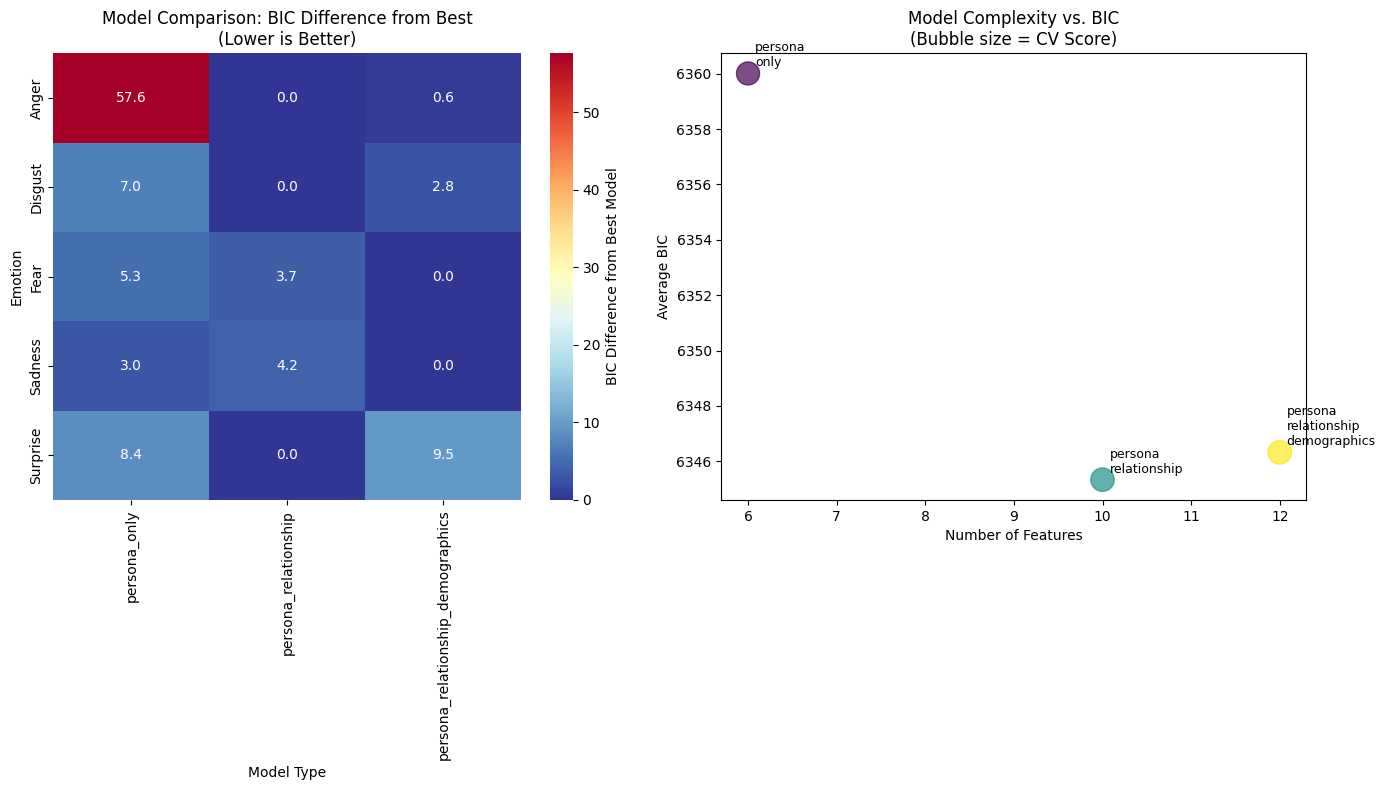


COMPREHENSIVE EXTENDED ANALYSIS SUMMARY

Dataset: 5749 posts analyzed
Models fitted: 3 different specifications
Emotions analyzed: 5

1. MODEL SELECTION SUMMARY (based on BIC):
--------------------------------------------------
persona_relationship          : 3/5 emotions (60%)
persona_relationship_demographics: 2/5 emotions (40%)

2. AVERAGE MODEL PERFORMANCE:
--------------------------------------------------
persona_only                  : CV=0.550±0.018, BIC=6360.0, Features=6
persona_relationship          : CV=0.570±0.021, BIC=6345.3, Features=10
persona_relationship_demographics: CV=0.579±0.020, BIC=6346.3, Features=12

3. BEST MODEL FOR EACH EMOTION:
--------------------------------------------------
Anger       : persona_relationship      (BIC=6652.6, CV=0.584)
Disgust     : persona_relationship      (BIC=7734.1, CV=0.592)
Fear        : persona_relationship_demographics (BIC=7562.4, CV=0.571)
Sadness     : persona_relationship_demographics (BIC=3467.3, CV=0.592)
Surprise    : 

In [175]:
all_results, comparison_df, best_models = run_extended_analysis(df_clean)

In [176]:
df_clean.columns

Index(['author', 'created_utc', 'id', 'link_flair_text', 'num_comments',
       'permalink', 'score', 'selftext', 'title', 'name', 'author_fullname',
       'word_count', 'created_datetime', 'year', 'sentences_topics',
       'sentences_labels', 'Label', 'sentences', 'persona_0_prob',
       'persona_1_prob', 'persona_2_prob', 'persona_3_prob', 'persona_4_prob',
       'persona_5_prob', 'dominant_persona', 'emotion__anger', 'emotion__fear',
       'emotion__sadness', 'emotion__disgust', 'emotion__surprise',
       'age_group', 'gender', 'relationship_cat'],
      dtype='object')

In [180]:
len(df_clean)

5749

In [177]:
# Check if there are any persona with 2 equal top persona probs
top_probs = df_clean[['persona_0_prob', 'persona_1_prob', 'persona_2_prob', 
                      'persona_3_prob', 'persona_4_prob', 'persona_5_prob']].apply(
    lambda row: row.sort_values(ascending=False).values, axis=1
)

rows_with_tie = top_probs.apply(lambda x: x[0] == x[1])
df_clean[rows_with_tie]

,author,created_utc,id,link_flair_text,num_comments,permalink,score,selftext,title,name,...,persona_5_prob,dominant_persona,emotion__anger,emotion__fear,emotion__sadness,emotion__disgust,emotion__surprise,age_group,gender,relationship_cat


In [ ]:
# Ok we're good then!

In [182]:
# A bit of cleaner formatting...
df_clean['dominant_persona'] = df_clean['dominant_persona'].astype(int)

In [183]:
df_clean.to_pickle('data/emo_regression/df_reg')

In [154]:
def prepare_features(df, feature_set='persona_only'):
    """
    Prepare feature sets for different model configurations
    
    Parameters:
    - df: input dataframe
    - feature_set: 'persona_only', 'persona_relationship', 'persona_relationship_demographics'
    
    Returns:
    - features_df: prepared features dataframe
    - feature_names: list of feature names
    """
    # Start with CLR-transformed persona probabilities
    persona_probs = df[persona_cols]
    clr_features = centered_log_ratio_transform(persona_probs)
    clr_features.columns = [f'CLR_{col}' for col in persona_cols]
    
    # Initialize features with CLR personas
    features_list = [clr_features]
    feature_names = clr_features.columns.tolist()
    
    if feature_set in ['persona_relationship', 'persona_relationship_demographics']:
        # Add relationship categorical variable (one-hot encoded)
        relationship_dummies = pd.get_dummies(df['relationship_cat'], prefix='relationship', drop_first=True)
        features_list.append(relationship_dummies)
        feature_names.extend(relationship_dummies.columns.tolist())
        
        if feature_set == 'persona_relationship_demographics':
            # Add demographics
            # Gender (binary encoded)
            gender_encoded = (df['gender'] == 'f').astype(int)
            gender_df = pd.DataFrame({'gender_female': gender_encoded}, index=df.index)
            features_list.append(gender_df)
            feature_names.extend(['gender_female'])
            
            # Age group (binary encoded)
            age_encoded = (df['age_group'] == 'adult').astype(int)
            age_df = pd.DataFrame({'age_adult': age_encoded}, index=df.index)
            features_list.append(age_df)
            feature_names.extend(['age_adult'])
    
    # Combine all features
    features_df = pd.concat(features_list, axis=1)
    
    return features_df, feature_names

In [155]:
def calculate_bic(model, X, y):
    """
    Calculate BIC for logistic regression model
    
    BIC = -2 * log-likelihood + k * log(n)
    where k is number of parameters and n is number of observations
    """
    # Get predicted probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Calculate log-likelihood
    # Avoid log(0) by clipping probabilities
    y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
    log_likelihood = np.sum(y * np.log(y_pred_proba) + (1 - y) * np.log(1 - y_pred_proba))
    
    # Number of parameters (coefficients + intercept)
    k = X.shape[1] + 1
    
    # Number of observations
    n = len(y)
    
    # Calculate BIC
    bic = -2 * log_likelihood + k * np.log(n)
    
    return bic

In [157]:
def fit_emotion_models_extended(cv_folds=5, alphas=None):
    """
    Fit logistic regression models for each emotion using different feature sets
    """
    if alphas is None:
        alphas = np.logspace(-4, 2, 50)
    
    feature_sets = {
        'persona_only': 'Persona probabilities only',
        'persona_relationship': 'Persona + Relationship',
        'persona_relationship_demographics': 'Persona + Relationship + Demographics'
    }
    
    all_results = {}
    
    for feature_set, description in feature_sets.items():
        print(f"\n{'='*80}")
        print(f"FEATURE SET: {description.upper()}")
        print('='*80)
        
        # Prepare features for this set
        features_df, feature_names = prepare_features(df_clean, feature_set)
        
        # Standardize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features_df)
        features_scaled_df = pd.DataFrame(features_scaled, 
                                        columns=feature_names,
                                        index=features_df.index)
        
        results = {}
        
        for emotion in emotion_cols:
            print(f"\n--- Analyzing {emotion.replace('emotion__', '').upper()} ---")
            
            y = df_clean[emotion]
            
            # Check class balance
            pos_rate = y.mean()
            print(f"Positive class rate: {pos_rate:.3f}")
            
            if pos_rate < 0.01 or pos_rate > 0.99:
                print(f"Warning: Extremely imbalanced classes for {emotion}")
            
            # Use LogisticRegressionCV with elasticnet for feature selection
            model = LogisticRegressionCV(
                Cs=1/alphas,  # Convert alphas to C values
                cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.1, 0.5, 0.7, 0.9],  # Mix of L1 and L2
                max_iter=1000,
                random_state=42,
                scoring='roc_auc' if pos_rate > 0.1 else 'balanced_accuracy'
            )
            
            # Fit model
            model.fit(features_scaled, y)
            
            # Calculate BIC
            bic = calculate_bic(model, features_scaled, y)
            
            # Cross-validation performance
            cv_scores = cross_val_score(
                model, features_scaled, y, 
                cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
                scoring='roc_auc' if pos_rate > 0.1 else 'balanced_accuracy'
            )
            
            # Store results
            results[emotion] = {
                'model': model,
                'cv_scores': cv_scores,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'coefficients': model.coef_[0],
                'feature_names': feature_names,
                'best_C': model.C_[0],
                'best_l1_ratio': model.l1_ratio_[0],
                'bic': bic,
                'n_features': len(feature_names),
                'feature_set': feature_set
            }
            
            print(f"Cross-validation {model.scoring}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
            print(f"Best C: {model.C_[0]:.4f}, Best L1 ratio: {model.l1_ratio_[0]:.3f}")
            print(f"BIC: {bic:.2f} (n_features: {len(feature_names)})")
        
        all_results[feature_set] = {
            'results': results,
            'features_scaled_df': features_scaled_df,
            'description': description
        }
    
    return all_results

In [158]:
# Run the extended analysis
print("Starting Extended Regression Analysis...")
all_results = fit_emotion_models_extended()

Starting Extended Regression Analysis...

FEATURE SET: PERSONA PROBABILITIES ONLY

--- Analyzing ANGER ---
Positive class rate: 0.733
Cross-validation roc_auc: 0.531 ± 0.020
Best C: 0.0543, Best L1 ratio: 0.700
BIC: 6710.23 (n_features: 6)

--- Analyzing FEAR ---
Positive class rate: 0.634
Cross-validation roc_auc: 0.547 ± 0.017
Best C: 0.0954, Best L1 ratio: 0.500
BIC: 7567.66 (n_features: 6)

--- Analyzing SADNESS ---
Positive class rate: 0.912
Cross-validation roc_auc: 0.553 ± 0.035
Best C: 0.0176, Best L1 ratio: 0.700
BIC: 3470.37 (n_features: 6)

--- Analyzing DISGUST ---
Positive class rate: 0.587
Cross-validation roc_auc: 0.579 ± 0.018
Best C: 8.6851, Best L1 ratio: 0.100
BIC: 7741.14 (n_features: 6)

--- Analyzing SURPRISE ---
Positive class rate: 0.234
Cross-validation roc_auc: 0.542 ± 0.013
Best C: 0.0133, Best L1 ratio: 0.700
BIC: 6310.65 (n_features: 6)

FEATURE SET: PERSONA + RELATIONSHIP

--- Analyzing ANGER ---
Positive class rate: 0.733
Cross-validation roc_auc: 0.584 ±

In [159]:
def compare_models_bic(all_results):
    """
    Compare models using BIC and create summary table
    """
    print("\n" + "="*80)
    print("MODEL COMPARISON - BIC SCORES")
    print("="*80)
    
    comparison_data = []
    
    for emotion in emotion_cols:
        emotion_name = emotion.replace('emotion__', '').title()
        print(f"\n{emotion_name}:")
        print("-" * (len(emotion_name) + 1))
        
        emotion_results = {}
        for feature_set, data in all_results.items():
            if emotion in data['results']:
                result = data['results'][emotion]
                emotion_results[feature_set] = {
                    'bic': result['bic'],
                    'cv_score': result['cv_mean'],
                    'n_features': result['n_features'],
                    'description': data['description']
                }
                
                comparison_data.append({
                    'Emotion': emotion_name,
                    'Feature_Set': feature_set,
                    'Description': data['description'],
                    'BIC': result['bic'],
                    'CV_Score': result['cv_mean'],
                    'N_Features': result['n_features']
                })
        
        # Find best model (lowest BIC)
        if emotion_results:
            best_model = min(emotion_results.items(), key=lambda x: x[1]['bic'])
            
            for feature_set, metrics in emotion_results.items():
                is_best = feature_set == best_model[0]
                marker = " *** BEST" if is_best else ""
                print(f"  {metrics['description']:35s}: BIC = {metrics['bic']:8.2f}, "
                      f"CV = {metrics['cv_score']:.3f}, Features = {metrics['n_features']:2d}{marker}")
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Overall summary
    print(f"\n{'='*80}")
    print("OVERALL MODEL SELECTION SUMMARY")
    print("="*80)
    
    best_models = comparison_df.loc[comparison_df.groupby('Emotion')['BIC'].idxmin()]
    
    feature_set_wins = best_models['Feature_Set'].value_counts()
    print(f"\nBest model by emotion (based on BIC):")
    for _, row in best_models.iterrows():
        print(f"  {row['Emotion']:12s}: {row['Description']}")
    
    print(f"\nFeature set performance:")
    for feature_set, count in feature_set_wins.items():
        feature_desc = all_results[feature_set]['description']
        print(f"  {feature_desc:35s}: {count}/{len(emotion_cols)} emotions")
    
    return comparison_df

In [160]:
# Compare models using BIC
comparison_df = compare_models_bic(all_results)


MODEL COMPARISON - BIC SCORES

Anger:
------
  Persona probabilities only         : BIC =  6710.23, CV = 0.531, Features =  6
  Persona + Relationship             : BIC =  6651.93, CV = 0.584, Features = 10 *** BEST
  Persona + Relationship + Demographics: BIC =  6652.19, CV = 0.590, Features = 12

Fear:
-----
  Persona probabilities only         : BIC =  7567.66, CV = 0.547, Features =  6
  Persona + Relationship             : BIC =  7566.12, CV = 0.561, Features = 10
  Persona + Relationship + Demographics: BIC =  7561.87, CV = 0.569, Features = 12 *** BEST

Sadness:
--------
  Persona probabilities only         : BIC =  3470.37, CV = 0.553, Features =  6
  Persona + Relationship             : BIC =  3474.21, CV = 0.565, Features = 10
  Persona + Relationship + Demographics: BIC =  3467.35, CV = 0.591, Features = 12 *** BEST

Disgust:
--------
  Persona probabilities only         : BIC =  7741.14, CV = 0.579, Features =  6
  Persona + Relationship             : BIC =  7741.73, CV = 

In [171]:
def plot_bic_comparison(comparison_df, figsize=(18, 8)):
    """
    Create visualization comparing BIC scores across models
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # BIC comparison plot
    pivot_bic = comparison_df.pivot(index='Emotion', columns='Description', values='BIC')
    pivot_bic.plot(kind='bar', ax=ax1, rot=45)
    ax1.set_title('BIC Scores by Model and Emotion\n(Lower is Better)')
    ax1.set_ylabel('BIC Score')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(axis='y', alpha=0.3)
    
    # CV Score comparison plot
    pivot_cv = comparison_df.pivot(index='Emotion', columns='Description', values='CV_Score')
    pivot_cv.plot(kind='bar', ax=ax2, rot=45)
    ax2.set_title('Cross-Validation Scores by Model and Emotion\n(Higher is Better)')
    ax2.set_ylabel('CV Score')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    return fig

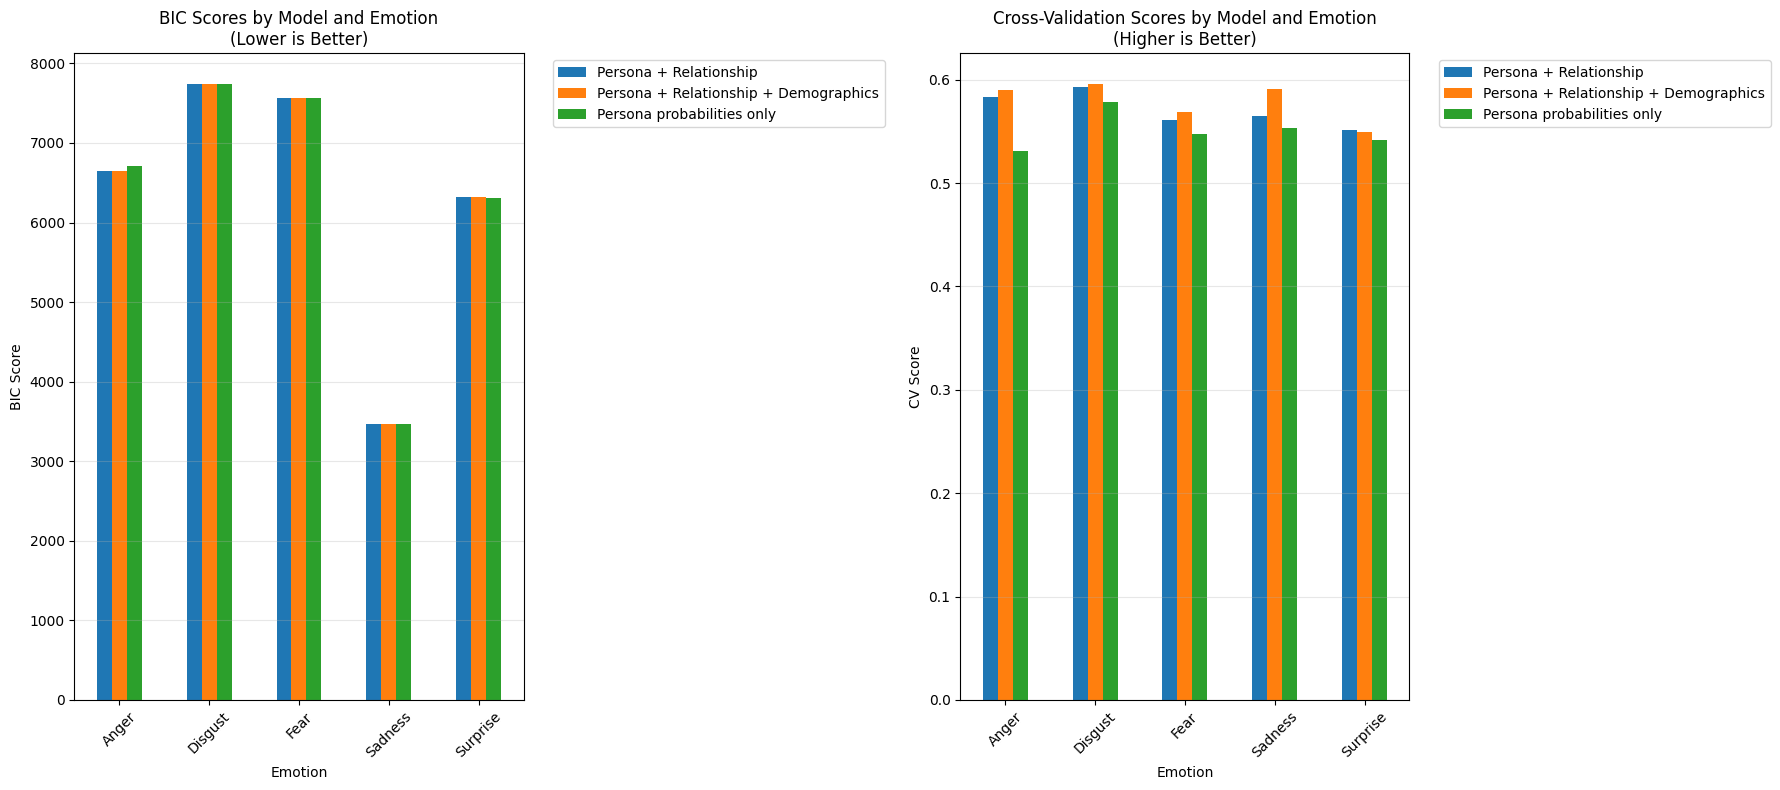

In [172]:
# Create visualizations
fig = plot_bic_comparison(comparison_df)
plt.show()

In [163]:
def interpret_coefficients_extended(all_results, min_coeff_threshold=0.01):
    """
    Interpret coefficients for the best models based on BIC
    """
    print("\n" + "="*80)
    print("COEFFICIENT INTERPRETATION - BEST MODELS")
    print("="*80)
    
    # Find best model for each emotion
    comparison_data = []
    for emotion in emotion_cols:
        emotion_bics = {}
        for feature_set, data in all_results.items():
            if emotion in data['results']:
                emotion_bics[feature_set] = data['results'][emotion]['bic']
        
        if emotion_bics:
            best_feature_set = min(emotion_bics.items(), key=lambda x: x[1])[0]
            comparison_data.append((emotion, best_feature_set))
    
    interpretation_data = []
    
    for emotion, best_feature_set in comparison_data:
        result = all_results[best_feature_set]['results'][emotion]
        emotion_name = emotion.replace('emotion__', '').upper()
        
        print(f"\n{emotion_name} (Best model: {all_results[best_feature_set]['description']}):")
        print("-" * (len(emotion_name) + len(all_results[best_feature_set]['description']) + 15))
        
        coeffs = result['coefficients']
        features = result['feature_names']
        
        # Sort coefficients by magnitude
        coeff_df = pd.DataFrame({
            'Feature': features,
            'Coefficient': coeffs,
            'Abs_Coefficient': np.abs(coeffs)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        # Only show coefficients above threshold
        significant_coeffs = coeff_df[coeff_df['Abs_Coefficient'] > min_coeff_threshold]
        
        if len(significant_coeffs) == 0:
            print("  No coefficients above threshold - model may not be informative")
            continue
        
        for _, row in significant_coeffs.iterrows():
            feature = row['Feature']
            coeff = row['Coefficient']
            direction = "increases" if coeff > 0 else "decreases"
            
            # Interpret different types of features
            if feature.startswith('CLR_persona_'):
                persona_num = feature.replace('CLR_persona_', '').replace('_prob', '')
                interpretation = f"Higher probability of Persona {persona_num} {direction} odds of {emotion_name}"
            elif feature.startswith('relationship_'):
                rel_type = feature.replace('relationship_', '')
                interpretation = f"Relationship type '{rel_type}' {direction} odds of {emotion_name} (vs. reference category)"
            elif feature == 'gender_female':
                interpretation = f"Being female {direction} odds of {emotion_name} (vs. male)"
            elif feature == 'age_adult':
                interpretation = f"Being adult {direction} odds of {emotion_name} (vs. adolescent)"
            else:
                interpretation = f"Feature '{feature}' {direction} odds of {emotion_name}"
            
            print(f"  {feature}: {coeff:+.4f}")
            print(f"    → {interpretation}")
            
            interpretation_data.append({
                'Emotion': emotion_name,
                'Feature': feature,
                'Coefficient': coeff,
                'Model': all_results[best_feature_set]['description']
            })
    
    return pd.DataFrame(interpretation_data)

def enhanced_summary_report(all_results, comparison_df, interpretation_df):
    """
    Generate comprehensive summary with model comparison
    """
    print("\n" + "="*100)
    print("ENHANCED ANALYSIS SUMMARY")
    print("="*100)
    
    print(f"\nDataset: {len(df_clean)} posts analyzed")
    print(f"Emotions analyzed: {len(emotion_cols)}")
    print(f"Model configurations tested: {len(all_results)}")
    
    # Feature set summary
    print(f"\nFeature sets tested:")
    for feature_set, data in all_results.items():
        sample_result = list(data['results'].values())[0]
        print(f"  • {data['description']}: {sample_result['n_features']} features")
    
    # Model selection results
    print(f"\n1. MODEL SELECTION RESULTS (BIC-based):")
    print("-" * 50)
    best_models = comparison_df.loc[comparison_df.groupby('Emotion')['BIC'].idxmin()]
    feature_set_wins = best_models['Description'].value_counts()
    
    for desc, count in feature_set_wins.items():
        print(f"{desc:35s}: {count}/{len(emotion_cols)} emotions ({100*count/len(emotion_cols):.1f}%)")
    
    # Performance summary
    print(f"\n2. PERFORMANCE SUMMARY:")
    print("-" * 30)
    for emotion in emotion_cols:
        emotion_name = emotion.replace('emotion__', '').title()
        emotion_data = comparison_df[comparison_df['Emotion'] == emotion_name]
        best_row = emotion_data.loc[emotion_data['BIC'].idxmin()]
        
        print(f"{emotion_name:12s}: {best_row['Description']} "
              f"(BIC: {best_row['BIC']:.1f}, CV: {best_row['CV_Score']:.3f})")
    
    # Key findings from best models
    print(f"\n3. KEY FINDINGS FROM BEST MODELS:")
    print("-" * 40)
    if len(interpretation_df) > 0:
        strong_effects = interpretation_df[
            np.abs(interpretation_df['Coefficient']) > 0.1
        ].sort_values('Coefficient', key=abs, ascending=False)
        
        if len(strong_effects) > 0:
            print("Strongest effects (|coefficient| > 0.1):")
            for _, row in strong_effects.head(10).iterrows():
                print(f"  • {row['Emotion']} ← {row['Feature']}: {row['Coefficient']:+.3f}")
        else:
            print("No strong effects found (|coefficients| < 0.1)")
    
    # Recommendations
    print(f"\n4. RECOMMENDATIONS:")
    print("-" * 25)
    most_successful = feature_set_wins.index[0] if len(feature_set_wins) > 0 else "None"
    print(f"• Best overall model: {most_successful}")
    
    avg_improvement = {}
    for desc in comparison_df['Description'].unique():
        desc_data = comparison_df[comparison_df['Description'] == desc]
        avg_improvement[desc] = desc_data['CV_Score'].mean()
    
    best_performance = max(avg_improvement.items(), key=lambda x: x[1])
    print(f"• Best average performance: {best_performance[0]} (CV: {best_performance[1]:.3f})")

In [164]:
# Interpret coefficients for best models
interpretation_df = interpret_coefficients_extended(all_results)

# Generate enhanced summary
enhanced_summary_report(all_results, comparison_df, interpretation_df)


COEFFICIENT INTERPRETATION - BEST MODELS

ANGER (Best model: Persona + Relationship):
------------------------------------------
  relationship_parent: +0.1245
    → Relationship type 'parent' increases odds of ANGER (vs. reference category)
  relationship_partner: -0.1181
    → Relationship type 'partner' decreases odds of ANGER (vs. reference category)
  relationship_friend: -0.1136
    → Relationship type 'friend' decreases odds of ANGER (vs. reference category)
  relationship_sibling: +0.0814
    → Relationship type 'sibling' increases odds of ANGER (vs. reference category)
  CLR_persona_4_prob: +0.0626
    → Higher probability of Persona 4 increases odds of ANGER
  CLR_persona_1_prob: +0.0536
    → Higher probability of Persona 1 increases odds of ANGER
  CLR_persona_2_prob: -0.0446
    → Higher probability of Persona 2 decreases odds of ANGER
  CLR_persona_5_prob: -0.0297
    → Higher probability of Persona 5 decreases odds of ANGER
  CLR_persona_3_prob: -0.0215
    → Higher pro